## Random Forest models on the EFs
Run Random Forest on all EFs and establish feature importance. The results will then be used in the deep learning models.

This model is adapted from the Basic_models.ipynb and includes functions that are copied.


# Imports

In [ ]:
%%capture
!pip install geopandas
!pip install pandas --upgrade

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import xgboost
import os

from google.colab import drive
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import shapely

In [ ]:
from typing import List, Union
from pathlib import Path
from functools import reduce
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, 
                             average_precision_score, precision_recall_curve, auc, PrecisionRecallDisplay)
# TODO: amalgamate these
from sklearn import metrics


# Function definitions

In [ ]:
def check_files_in_list_exist(
    file_list: Union[List[str], List[Path]]
    ):
    """State which files don't exist and remove from list"""
    files_found = []
    for fl in file_list:
        # attempt conversion to Path object if necessary
        if type(fl) != Path:
            try:
                fl = Path(fl)
            except TypeError:
                print(f'{fl} could not be converted to Path object')
        
        if fl.is_file():
            files_found += fl,
        else:
            print(f'{fl} not found. Removing from list.')

    return files_found


def read_and_merge_pkls(
    pkl_paths: Union[List[str], List[Path]]
) -> pd.DataFrame:
    """Read in pkl files from list of file paths and merge on index"""
    # check all files exist
    pkl_paths_present = check_files_in_list_exist(pkl_paths)
    df_list = [pd.read_pickle(pkl) for pkl in pkl_paths_present]

    return reduce(lambda df1,df2: pd.merge(df1,df2,left_index=True,right_index=True), df_list)


def rename_and_drop_duplicated_cols(
    df: pd.DataFrame
) -> pd.DataFrame:
    """Drop columns which are copies of others and rename the 'asdf_x' headers which would have resulted"""
    # need to ensure no bad types first
    df = drop_cols_containing_lists(df)
    # remove duplicated columns
    dropped_df = df.T.drop_duplicates().T
    # rename columns for clarity (especially those which are shared between dfs). Will be able to remove most with better
    # column naming further up the process
    new_col_names = {col: col.replace('_x', '') for col in dropped_df.columns if col.endswith('_x')}
    
    return dropped_df.rename(columns=new_col_names)


def drop_cols_containing_lists(
    df: pd.DataFrame
) -> pd.DataFrame:
    """It seemed like the best solution at the time: and to be fair, I can't really think of better...
    N.B. for speed, only looks at values in first row – if there is a multi-type column, this would be the least of
    our worries...
    """
    df = df.loc[:, df.iloc[0].apply(lambda x: type(x) != list)]

    return df


def assign_predictor(
    df: pd.DataFrame,
    col_name: str,
    drop_classes: List[int] = None,
    binary_classification: bool = True
) -> pd.DataFrame:
    """Assign column as predictor value, and choose whether binary or multi-class classification. Can choose to drop
    classes."""
    df["y"] = df[col_name].astype(int)

    if binary_classification:
        df.loc[df["y"] > 0, "y"] = 1

    if drop_classes is not None:
        # drop any classes in 
        df = df.loc[~df['y'].isin(drop_classes)]

    return df


def replace_cols_with_mean(
    df: pd.DataFrame, 
    col_names: List[str]
) -> pd.DataFrame:
    """Replace values in a column with the mean value"""
    for col in col_names:
        df.loc[df[col] == 0, col] = df[col][df[col] > 0].mean()
    
    return df





def train_test_display_model(
    df: pd.DataFrame,
    var_col_names: List[str],
    model_name: str = 'LogisticRegression',
    y_col: str = 'y',
    test_size: float = 0.25,
    random_state: int = 1
) -> list:
    """Specify columns in a df to use to train and test model. Currently available models: 'LogisticRegression', 
    'RandomForest'
    """

    x_train, x_test, y_train, y_test = train_test_split(
        df[var_col_names],
        df[y_col],
        test_size=test_size,random_state=random_state)

    # select chosen model
    if model_name == 'LogisticRegression':
        model = LogisticRegression()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.coef_[0]
    elif model_name == 'RandomForest':
        model = RandomForestClassifier()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.feature_importances_  

    predictions = model.predict(x_test)
    score = model.score(x_test, y_test)
    y_score = model.predict_proba(x_test)

    fig,(ax_imp,ax_conf) = plt.subplots(1, 2, figsize=[22,10])
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(f'Current model: {model_name.upper()}')

    plot_confusion_matrix(y_test, predictions, score, ax=ax_conf)
    plot_importances(var_col_names, importance, ax=ax_imp)
    plt.show()

    more_performance_scores(predictions,y_test)

    return model, predictions, x_train, x_test, y_train, y_test, score, y_score, importance


def more_performance_scores(
    predictions: List,
    y_test: List
):
    """Return extra performance scores"""

    # F1 score = (2*precision*recall)/(precision+recall)
    f1_score_val = f1_score(predictions, y_test, average=None)
    f1_score_macro = f1_score(predictions, y_test, average='macro')
    f1_score_weighted = f1_score(predictions, y_test, average='weighted')
    print(f'f1 score per class: {f1_score_val}')
    print(f'f1 score macro: {f1_score_macro}')
    print(f'weighted f1 score: {f1_score_weighted}')  # seems weirdly high

    # precision
    print(f'precision score: {precision_score(predictions, y_test, average=None)}')

    # recall
    print(f'recall score: {recall_score(predictions, y_test, average=None)}')
    # balanced accuracy (unweighted average of recall obtained on each class)
    bal_acc = recall_score(predictions, y_test, average='macro')
    print(f'balanced accuracy: {bal_acc}')

    # accuracy (true predictions, OvR over all predictions)
    print(f'accuracy_score: {accuracy_score(predictions, y_test)}')


def plot_confusion_matrix(
    y_test: list,
    predictions: list,
    score: float,
    ax=None
):
    """Plot confusion matrix from y_test and inferred values"""

    confusion_matrix = metrics.confusion_matrix(y_test, predictions)
    # initialise axes if necessary
    ax = ax or plt.gca()
    sns.heatmap(confusion_matrix/np.sum(confusion_matrix), ax=ax, annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
    # formatting
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    # assign integer damage classes to labels
    xtick_labels = [int_to_label(el) for el in range(len(confusion_matrix))]
    ax.set_xticks(ax.get_xticks(),xtick_labels,rotation=45)
    ax.set_yticks(ax.get_yticks(),xtick_labels,rotation=45)
    ax.xaxis.set_label_position('top') 
    ax.xaxis.tick_top()

    if len(confusion_matrix) == 2:  # binary classification
      ax.set_title(f'Confusion matrix for binary classification \n Score: {score:.4f}', fontsize=18)
    else: # multiclass classification
      ax.set_title(f'Confusion matrix for multiclass classification \n Score: {score:.4f}', fontsize=18)

    return ax


def plot_importances(
    var_col_names: List[str],
    importances: List[float],
    num_params_to_show: int = None,
    ax=None
):
    """Visualise feature importance"""
    # initialise axes if necessary
    ax = ax or plt.gca()

    data = dict(zip(var_col_names, importances))
    sorted_data = dict(sorted(data.items(), key=lambda x: x[1], reverse=False))
    
    # if specified to show fewer, remove all but greatest n values
    if type(num_params_to_show) == int:
        nth_val = sorted(sorted_data.values(), reverse=True)[num_params_to_show-1]
        sorted_data = {k: v for k, v in sorted_data.items() if v >= nth_val}
        
    ax.barh(list(sorted_data.keys()), list(sorted_data.values()))

    # formatting
    ax.set_ylabel('Input variable')
    ax.set_xlabel('Feature importance')

    if type(num_params_to_show) == int:
        ax.set_title(f'Feature importance for model\nTop {num_params_to_show} most significant features', fontsize=18)
    else:
        ax.set_title('Feature importance for model\nAll features', fontsize=18)

    ax.grid(which='both', linewidth=0.3)
    ax.set_xlim(right=1.15*max(importances))

    for i, v in enumerate(sorted_data.values()):
        ax.text(v+.02*max(importances), i, f'{v:.3f}', ha='left', va='center_baseline')

    return ax


def train_test_model(
    model,
    trains: List[List],
    tests: List[List]
) -> List:
    """Train provided model. Trains in format [x_train, y_train]; similar with tests"""
    model.fit(trains[0], trains[1])
    predictions = model.predict(tests[0])
    model.score(tests[0], tests[1])

    return model


def plot_roc_curves(
    y_test: List[int],
    y_score: List[float]
):
    """Plot ROC (receiver operating characteristic) curve for each class"""
    fig, axes = plt.subplots(len(np.unique(y_test))//2, len(np.unique(y_test))//2, figsize=[15,15])
    axes = axes.ravel()
    clsses = [str(el) for el in np.unique(y_test)]

    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)

    for i,clss in enumerate(np.unique(y_test)):
        class_id = np.flatnonzero(label_binarizer.classes_ == clss)[0]

        metrics.RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{clss} vs the rest",
            color="darkorange",
            ax=axes[i]
        )

        axes[i].set_aspect('equal')
        axes[i].plot([0, 1], [0, 1], "k--", label="random choice level (AUC = 0.5)")
        axes[i].set_xlabel("False Positive Rate")
        axes[i].set_ylabel("True Positive Rate")
        axes[i].grid(which='both', linewidth=0.3)
        not_clss_list = '&'.join([x for x in clsses if x != str(clss)])
        axes[i].set_title(f"One-vs-Rest ROC curves:\n{int_to_label(clss)} vs {not_clss_list}")


# ROC AUC via macro average = (prec_1 + prec_2 + ... + prec_n) / n since imbalanced dataset
def plot_pr_curves(
    y_test: List[int],
    y_score: List[float]
):
    """Plot PR (precision-recall) curve for each class"""
    
    fig, axes = plt.subplots(len(np.unique(y_test))//2, len(np.unique(y_test))//2, figsize=[15,15])
    axes = axes.ravel()
    clsses = [str(el) for el in np.unique(y_test)]

    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)

    for i,clss in enumerate(np.unique(y_test)):
        PrecisionRecallDisplay.from_predictions(
            y_onehot_test[:, i], y_score[:, i], name='name', ax=axes[i])
        # formatting
        not_clss_list = '&'.join([x for x in clsses if x != str(clss)])
        axes[i].set_title(f"One-vs-Rest P-R curves:\n{int_to_label(clss)} vs {not_clss_list}")
        axes[i].grid(which='both', linewidth=0.3)


def calc_curves_macro_av(
    y_test: List[float],
    y_score: List[float],
    curve_type: str = 'pr'
):  
    """Calculate the macro average from a set of performance curves
    N.B. adapted largely from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    
    Parameters
    ----------
    y_test : List[float]
    y_score : List[float]
    curve_type : str defaults to 'pr'
        required curve. This can be either 'pr' (precision-recall) or 'roc' (receiver operating characteristic)
    """
    # store the fpr, tpr, and roc_auc for all averaging strategies

    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)
    # print(np.shape(y_onehot_test))
    # print(np.shape(y_score)[1])

    x_stats, y_stats, curve_aucs = dict(), dict(), dict()
    
    for i in range(np.shape(y_score)[1]):
        if curve_type == 'roc':
            x_stats[i], y_stats[i], _ = metrics.roc_curve(y_onehot_test[:, i], y_score[:, i])
        elif curve_type == 'pr':
            y_stats[i], x_stats[i], _ = metrics.precision_recall_curve(y_onehot_test[:, i], y_score[:, i])
        else:
            raise ValueError(f'Unknown curve type: {curve_type}')
        curve_aucs[i] = auc(x_stats[i], y_stats[i])
    
    ### TODO: comment and check functionality – seems too good! Think a debug would be useful here...
    # TODO: make sure all stats calculated
    # TODO: what's up with the fourth P-R curve?
    
    grid = np.linspace(0.0, 1.0, 1000)
    # Interpolate all ROC curves at these points
    mean_stat = np.zeros_like(grid)

    for i in range(len(x_stats)):
        mean_stat += np.interp(grid, x_stats[i], y_stats[i])  # linear interpolation

    # Average it and compute AUC
    mean_stat /= len(x_stats)

    x_stats["macro"] = grid
    y_stats["macro"] = mean_stat
    curve_aucs["macro"] = auc(x_stats["macro"], y_stats["macro"])

    print(f"Macro-averaged One-vs-Rest {curve_type.upper()} AUC score:\n{curve_aucs['macro']:.2f}")


def int_to_label(
    integer: int
) -> str:
    """Convert a numerical label to its corresponding text label"""
    label_dict = {0: 'undamaged', 1: 'minor damage', 2: 'major damage', 3: 'destroyed', 4: 'unclassified'}

    return label_dict[integer]


def pca_analysis(
    df: pd.DataFrame,
    feature_cols: list[str],
    target_col: str,
    components = None
):
    """Apply and visualise rudimentary PCA. Returns percentage variances, cumulative percentage variances, and plots
    explained variance against number of input features

    helped largely by this: https://towardsdatascience.com/using-principal-component-analysis-pca-for-machine-learning-b6e803f5bf1e
    TODO: better commenting, write documentation
    """
    # get the features and label from the original dataframe
    X = df[feature_cols]
    y = df[target_col]

    # performing standardization
    sc = StandardScaler()
    X_scaled = sc.fit_transform(X)

    pca = PCA(n_components = components)
    # perform PCA on the scaled data
    pca.fit(X_scaled);

    # print the explained variances
    print("Variances (Percentage):")
    print(pca.explained_variance_ratio_ * 100)
    print("Cumulative Variances (Percentage):")
    print(pca.explained_variance_ratio_.cumsum() * 100)

    plot_scree_plot(pca, components)


def plot_scree_plot(
    pca,
    components = None
):
    """Plot scree plot for PCA visualisation"""
    components = len(pca.explained_variance_ratio_) \
        if components is None else components

    _,ax = plt.subplots()
    ax.plot(range(1,components+1), 
            np.cumsum(pca.explained_variance_ratio_ * 100))
    ax.set_xlabel("Number of components")
    ax.set_ylabel("Explained variance (%)")
    ax.set_title('Scree plot for trained model')
    ax.hlines(xmin=0,xmax=components, y=95, color='k', linestyle='dotted', label='95% explained variance')
    ax.grid(which='major', linewidth=0.3)
    ax.grid(which='minor', linewidth=0.1)
    ax.set_xlim(xmin=0, xmax=components)
    plt.legend()
    plt.minorticks_on()

# Random forest on final version of EFs and find best representation of hurricane track (14/03)
- test out feature importance for hurricane track
- start only with ECMWF data

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
data_dir = "/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/"

Mounted at /content/drive/


In [ ]:
print(os.listdir('/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/EFs/weather_data'))

['isd-history.csv', 'xbd_obs_stations.pkl', 'xbd_weather_hourly.pkl', 'noaa_hurricanes.pkl', 'weather_stations.pkl', 'xbd_weather_station_files_hourly', 'xbd_obs_noaa_six_hourly.pkl', 'xbd_stations_info.pkl', 'hurricane_damages', 'ecmwf', 'noaa_xbd_hurricanes.pkl', 'xbd_obs_noaa_six_hourly_larger_dataset.pkl', 'LISANNE_DELETE_xbd_obs_noaa_six_hourly_larger_dataset.pkl', 'xbd_noaa_speeds.pkl']


In [ ]:
# NOAA weather EFs
df_noaa_xbd_pkl_path = os.path.join(data_dir, "EFs/weather_data/xbd_obs_noaa_six_hourly_larger_dataset.pkl")
# df_noaa_xbd = pd.read_pickle(df_noaa_xbd_pkl_path)
# ecmwf weather EFs
df_ecmwf_xbd_pkl_path = os.path.join(data_dir, "EFs/weather_data/ecmwf/xbd_ecmwf_points.pkl")
#df_ecmwf_xbd = pd.read_pickle(df_ecmwf_xbd_pkl_path)

# terrain efs
df_terrain_efs_path = os.path.join(data_dir, "processed_data/Terrian_EFs.pkl")
#df_terrain_ef = pd.read_pickle(df_terrain_efs_path)

# flood, storm surge and soil properties
df_topographic_efs_path = os.path.join(data_dir,"processed_data/df_points_posthurr_flood_risk_storm_surge_soil_properties.pkl")
# df_topographic_efs = pd.read_pickle(df_topographic_efs_path)

# distance to track, interpolated to different resolutions (ADD LATER)
df_distance_to_track = os.path.join(data_dir, "processed_data/shortest_dis2hurricanes_varying_res.pkl")
# df_distance = pd.read_pickle(df_distance_to_track)

In [ ]:
#ECMWF_pkl_paths = [df_ecmwf_xbd_pkl_path, df_terrain_efs_path, df_distance_to_track]
ECMWF_pkl_paths = [df_ecmwf_xbd_pkl_path, df_terrain_efs_path, df_topographic_efs_path,df_distance_to_track]
ECMWF_EF_df = read_and_merge_pkls(ECMWF_pkl_paths)
# EF_df_no_dups = rename_and_drop_duplicated_cols(EF_df)
#EF_df_no_dups

In [ ]:
NOAA_pkl_paths = [df_noaa_xbd_pkl_path, df_terrain_efs_path, df_topographic_efs_path,df_distance_to_track]
# pkl_paths = [df_noaa_xbd_pkl_path, df_terrain_efs_path, df_distance_to_track df_topographic_efs_path]
NOAA_EF_df = read_and_merge_pkls(NOAA_pkl_paths)
NOAA_df_no_dups = rename_and_drop_duplicated_cols(NOAA_EF_df)
# drop r_max_wind as it is a column full of NaNs
NOAA_df_no_dups = NOAA_df_no_dups.drop(columns=["r_max_wind"])

<ipython-input-4-a6ebfb6bf1a7>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'damage_class_x', 'disaster_name_x'} in the result is deprecated and will raise a MergeError in a future version.
  return reduce(lambda df1,df2: pd.merge(df1,df2,left_index=True,right_index=True), df_list)


In [ ]:
all_pkl_paths = [df_noaa_xbd_pkl_path, df_ecmwf_xbd_pkl_path, df_terrain_efs_path, df_topographic_efs_path, df_distance_to_track]
# pkl_paths = [df_noaa_xbd_pkl_path, df_terrain_efs_path, df_distance_to_track df_topographic_efs_path]
all_EF_df = read_and_merge_pkls(all_pkl_paths)
all_df_no_dups = rename_and_drop_duplicated_cols(all_EF_df)
# drop r_max_wind as it is a column full of NaNs
all_df_no_dups = all_df_no_dups.drop(columns=["r_max_wind"])

<ipython-input-4-a6ebfb6bf1a7>:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'damage_class_x', 'disaster_name_x'} in the result is deprecated and will raise a MergeError in a future version.
  return reduce(lambda df1,df2: pd.merge(df1,df2,left_index=True,right_index=True), df_list)


In [ ]:
NOAA_all_EF_features = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 'shortest_distance_to_track',
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'dis2hurricane_res10000m', 'dis2hurricane_res8000m',
       'dis2hurricane_res6000m', 'dis2hurricane_res4000m',
       'dis2hurricane_res2000m', 'dis2hurricane_res1000m',
       'dis2hurricane_res800m', 'dis2hurricane_res600m',
       'dis2hurricane_res400m', 'dis2hurricane_res200m']

In [ ]:
NOAA_all_EF_features_notrack = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength',
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'dis2hurricane_res10000m', 'dis2hurricane_res8000m',
       'dis2hurricane_res6000m', 'dis2hurricane_res4000m',
       'dis2hurricane_res2000m', 'dis2hurricane_res1000m',
       'dis2hurricane_res800m', 'dis2hurricane_res600m',
       'dis2hurricane_res400m', 'dis2hurricane_res200m']

In [ ]:
NOAA_weather_features = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength']

In [ ]:
ECMWF_all_EF_features = ['d2m', 't2m', 'tp', 'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro',
       'u10', 'v10','elevation', 'slope', 'aspect', 'dis2coast',
       'storm_surge', 'soil_density', 'sand_content', 'clay_content',
       'silt_content', 'dis2hurricane_res10000m',
       'dis2hurricane_res8000m', 'dis2hurricane_res6000m',
       'dis2hurricane_res4000m', 'dis2hurricane_res2000m',
       'dis2hurricane_res1000m', 'dis2hurricane_res800m',
       'dis2hurricane_res600m', 'dis2hurricane_res400m',
       'dis2hurricane_res200m']

In [ ]:
ECMWF_weather_features = ['d2m', 't2m', 'tp', 'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro',
       'u10', 'v10',]

In [ ]:
all_EF_features = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64', 'strength',
       'shortest_distance_to_track', 'd2m', 't2m', 'tp',
       'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro', 'u10', 'v10',
       'elevation', 'slope', 'aspect', 'dis2coast',
       'storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content', 'dis2hurricane_res10000m',
       'dis2hurricane_res8000m', 'dis2hurricane_res6000m',
       'dis2hurricane_res4000m', 'dis2hurricane_res2000m',
       'dis2hurricane_res1000m', 'dis2hurricane_res800m',
       'dis2hurricane_res600m', 'dis2hurricane_res400m',
       'dis2hurricane_res200m']

## Run all features with ECMWF

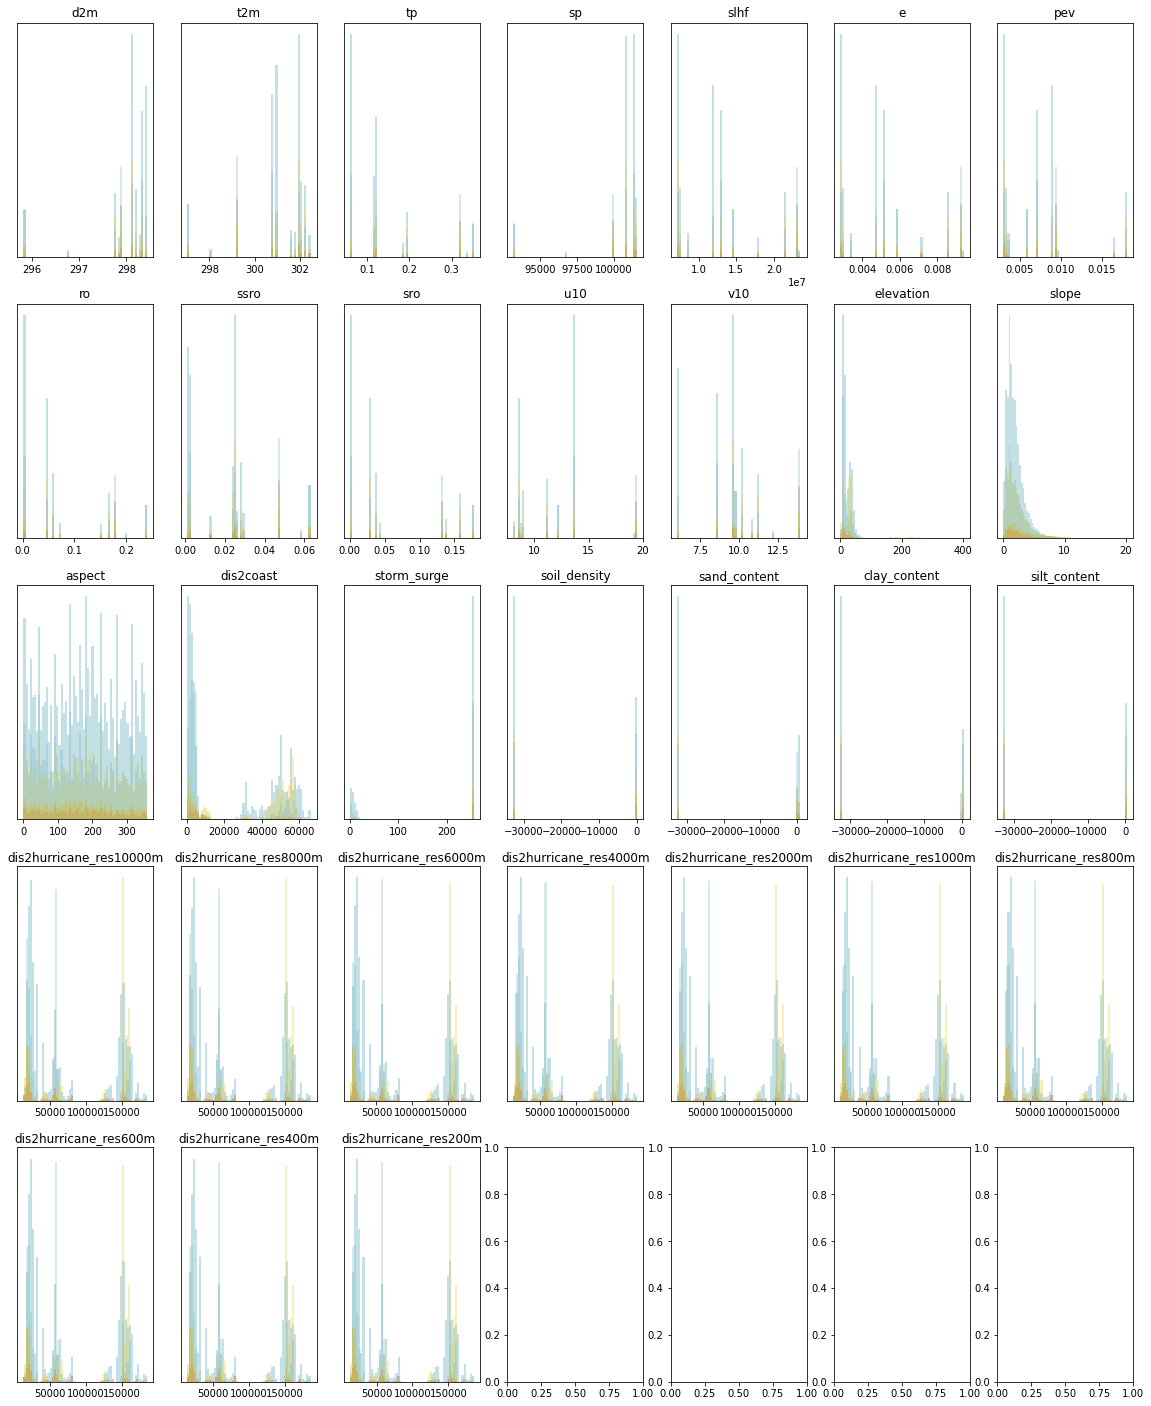

In [ ]:
ECMWF_EF_df = ECMWF_EF_df.dropna(subset=ECMWF_all_EF_features)

# TODO: make more clear
fig, axes = plt.subplots(5, 7, figsize=(20,25))	# better way to dynamically assign for a variable number of figures?

axes = axes.ravel()
bins = 60
palette = ["#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00"]

# for each feature
for f_ind, f in enumerate(ECMWF_all_EF_features):
	# and each damage class
	for t in ECMWF_EF_df['damage_class'].unique():
		damage_data = ECMWF_EF_df[ECMWF_EF_df['damage_class'] == t]
		axes[f_ind].hist(damage_data[f], bins=bins, color=palette[t], alpha=0.3)
		axes[f_ind].axes.get_yaxis().set_visible(False)
	axes[f_ind].set_title(f)
	# TODO: add overall legend
	# axes[f].legend

Variances (Percentage):
[3.87802732e+01 2.32330905e+01 1.09935788e+01 8.62540723e+00
 4.65020292e+00 3.19013387e+00 2.88919874e+00 2.73474524e+00
 2.26117304e+00 1.64068453e+00 4.31111443e-01 3.15043443e-01
 1.90580690e-01 2.87397355e-02 2.23981375e-02 1.20187885e-02
 7.16269781e-04 4.81688664e-04 3.90240417e-04 1.36224340e-05
 1.10107523e-05 5.25731086e-06 1.32276744e-06 2.90495861e-07
 1.82415798e-08 1.03050654e-09 4.48749086e-10 1.20316443e-10
 1.71536845e-11 5.60862461e-29 1.13309801e-29]
Cumulative Variances (Percentage):
[ 38.78027318  62.01336369  73.00694247  81.6323497   86.28255262
  89.47268649  92.36188523  95.09663047  97.35780351  98.99848804
  99.42959948  99.74464293  99.93522362  99.96396335  99.98636149
  99.99838028  99.99909655  99.99957824  99.99996848  99.9999821
  99.99999311  99.99999837  99.99999969  99.99999998 100.
 100.         100.         100.         100.         100.
 100.        ]


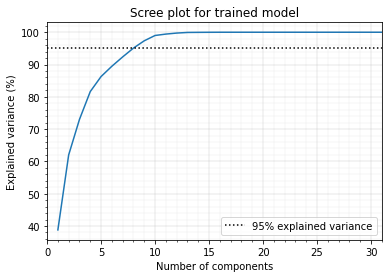

In [ ]:
pca_analysis(ECMWF_EF_df, ECMWF_all_EF_features, 'damage_class')

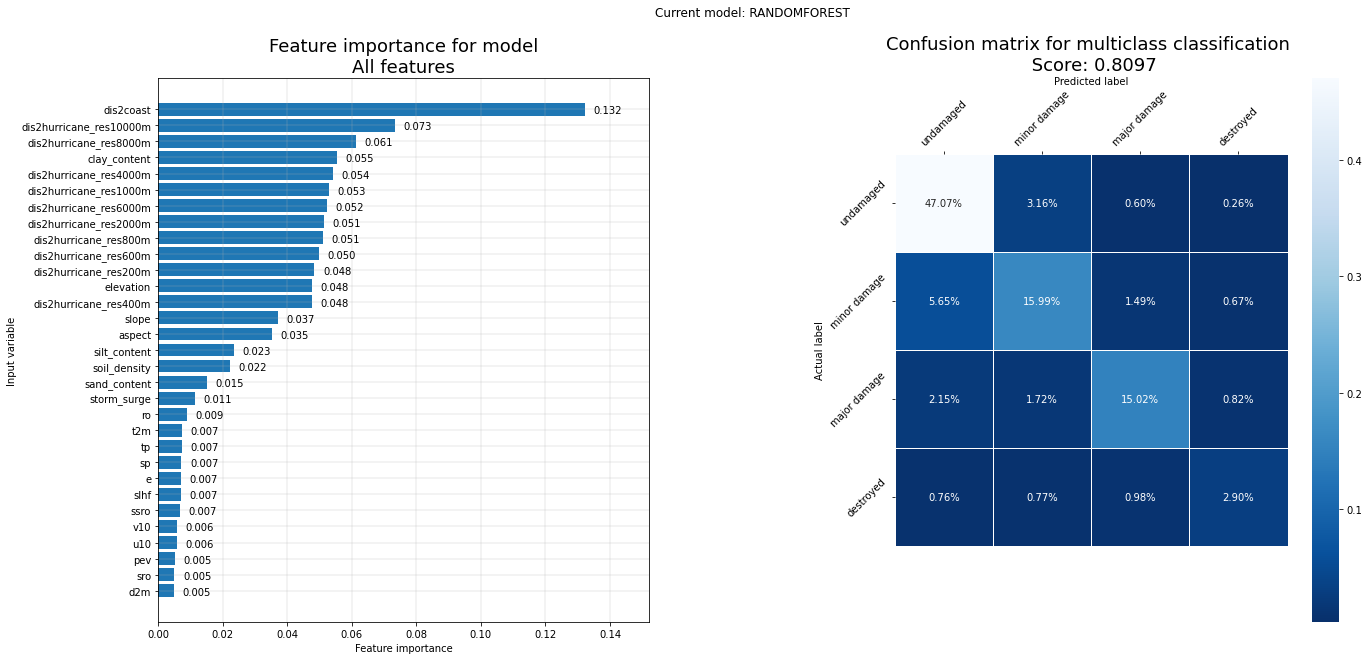

f1 score per class: [0.88216132 0.70387623 0.79472053 0.57636023]
f1 score macro: 0.7392795750062663
weighted f1 score: 0.8135569392653363
precision score: [0.92144389 0.67190726 0.7620326  0.53556485]
recall score: [0.84609115 0.7390393  0.83033849 0.62388302]
balanced accuracy: 0.7598379900998595
accuracy_score: 0.8097487247307765


In [ ]:
# assign target variable
ECMWF_df_model_ready = assign_predictor(ECMWF_EF_df, 'damage_class', drop_classes=[4], binary_classification=False)

# replace necessary columns with mean TODO: ask Ruari about this
#cols_for_mean = ['soil_density', 'sand_content', 'clay_content', 'silt_content']
#df_model_ready = replace_cols_with_mean(df_model_ready, cols_for_mean)
ECMWF_df_model_ready.head()

ECMWF_model, ECMWF_predictions, ECMWF_x_train, ECMWF_x_test, ECMWF_y_train, ECMWF_y_test, ECMWF_score, ECMWF_y_score, ECMWF_importances = train_test_display_model(
    ECMWF_df_model_ready, ECMWF_all_EF_features, model_name='RandomForest')

Macro-averaged One-vs-Rest ROC AUC score:
0.93
None
Macro-averaged One-vs-Rest PR AUC score:
1.00
None


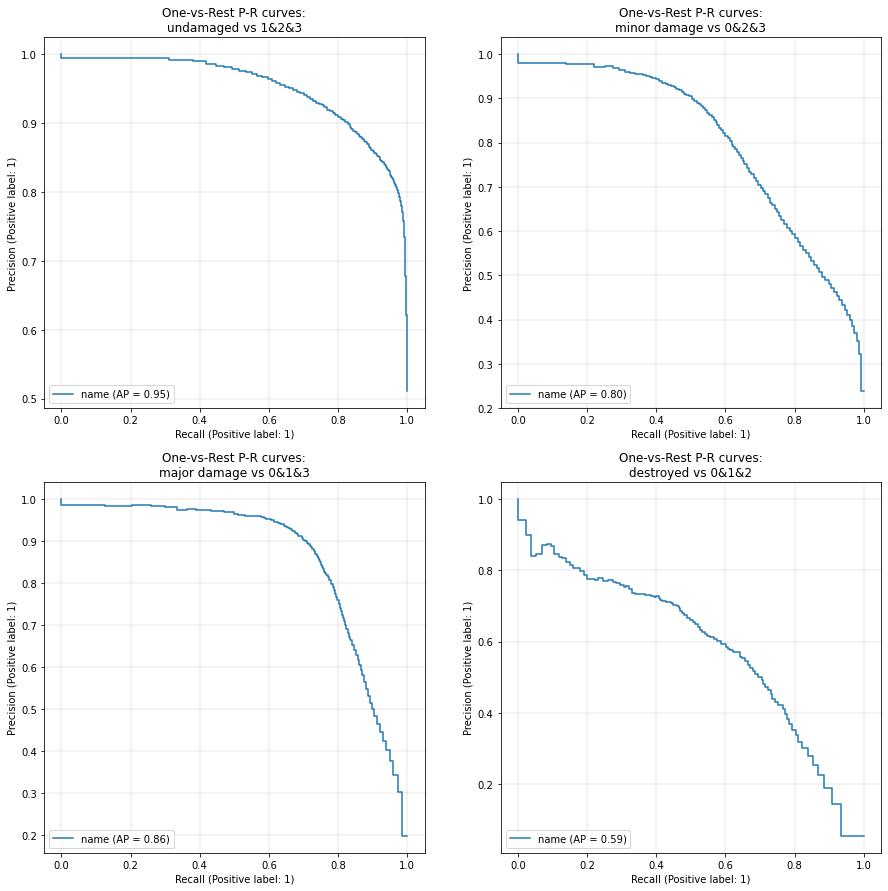

In [ ]:
print(calc_curves_macro_av(ECMWF_y_test, ECMWF_y_score, curve_type='roc'))
print(calc_curves_macro_av(ECMWF_y_test, ECMWF_y_score, curve_type='pr'))
plot_pr_curves(ECMWF_y_test, ECMWF_y_score)

## Run all features with NOAA

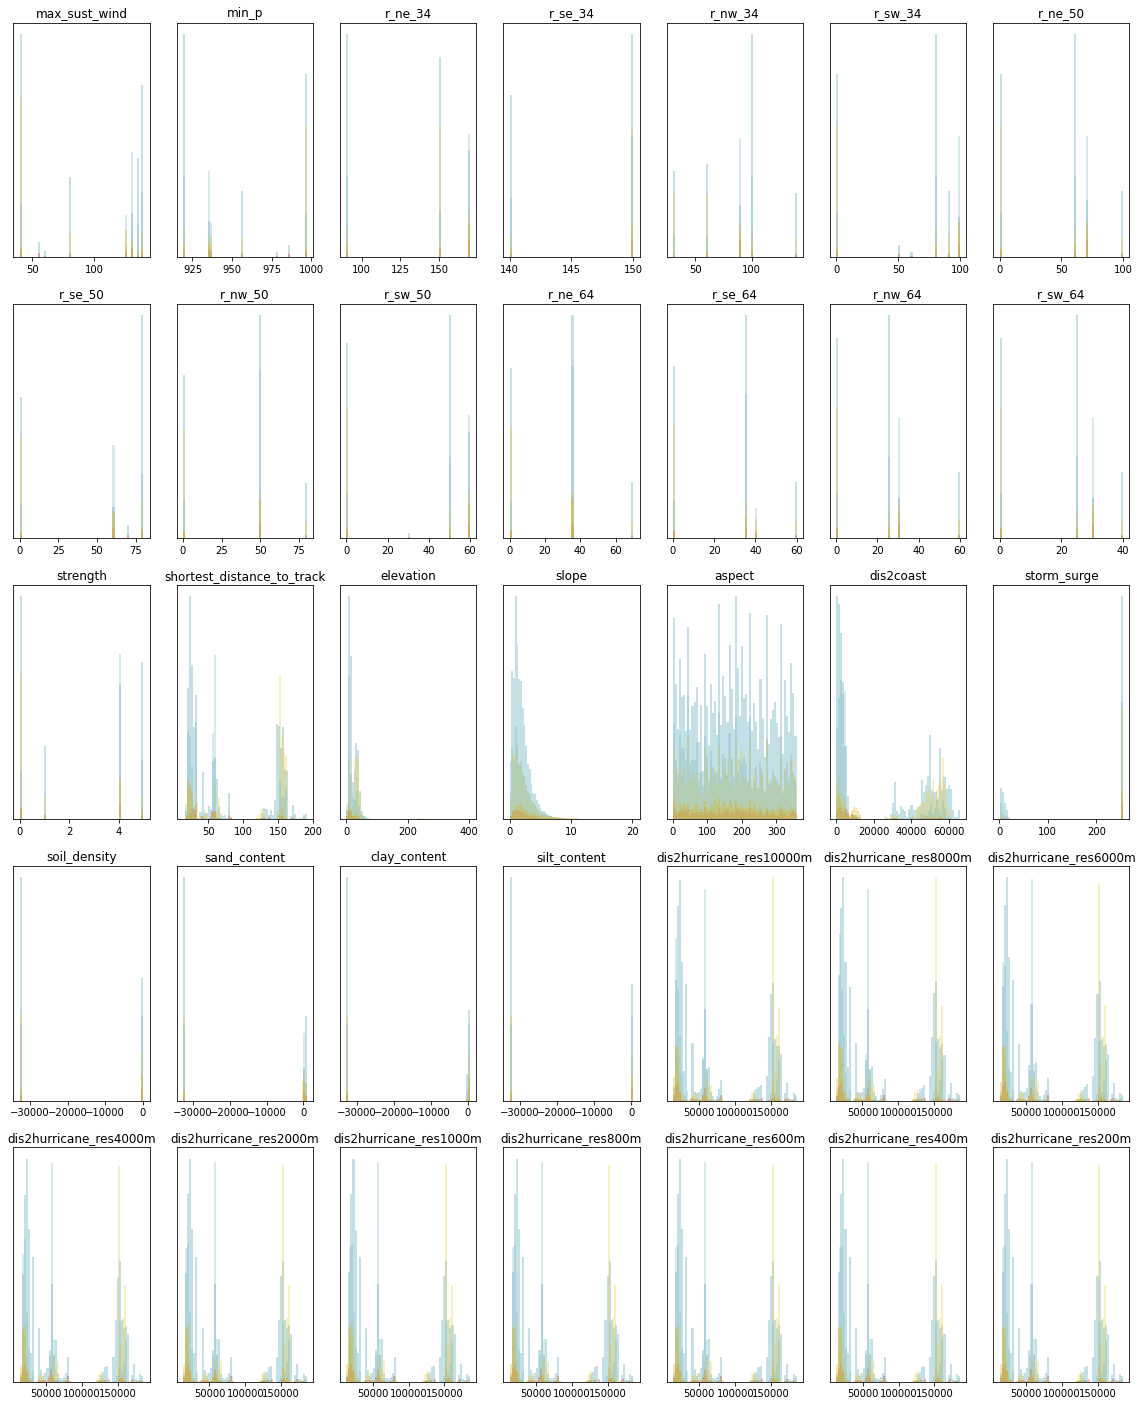

In [ ]:
NOAA_EF_df = NOAA_df_no_dups.dropna(subset=NOAA_all_EF_features)

# TODO: make more clear
fig, axes = plt.subplots(5, 7, figsize=(20,25))	# better way to dynamically assign for a variable number of figures?

axes = axes.ravel()
bins = 60
palette = ["#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00"]

# for each feature
for f_ind, f in enumerate(NOAA_all_EF_features):
	# and each damage class
	for t in NOAA_df_no_dups['damage_class'].unique():
		damage_data = NOAA_df_no_dups[NOAA_df_no_dups['damage_class'] == t]
		axes[f_ind].hist(damage_data[f], bins=bins, color=palette[t], alpha=0.3)
		axes[f_ind].axes.get_yaxis().set_visible(False)
	axes[f_ind].set_title(f)
	# TODO: add overall legend
	# axes[f].legend

Variances (Percentage):
[6.70748582e+01 1.35700347e+01 5.14555371e+00 4.26588950e+00
 2.82705339e+00 1.98275623e+00 1.60022572e+00 1.54276970e+00
 1.27285908e+00 2.81216124e-01 2.42555220e-01 9.09066766e-02
 4.43584323e-02 3.63866444e-02 1.71634301e-02 4.79059476e-03
 3.86889923e-04 2.13019673e-04 9.61567282e-06 8.61860377e-06
 3.40299020e-06 8.38028962e-07 2.01063824e-07 1.50875374e-08
 8.80363579e-10 3.87102626e-10 1.05052504e-10 1.48477451e-11
 2.66068293e-28 2.12911643e-29 3.87292214e-30 2.43390215e-30
 5.51545171e-31 3.80459477e-31 1.46563408e-31]
Cumulative Variances (Percentage):
[ 67.07485823  80.64489295  85.79044666  90.05633616  92.88338955
  94.86614577  96.4663715   98.0091412   99.28200028  99.5632164
  99.80577162  99.8966783   99.94103673  99.97742337  99.9945868
  99.9993774   99.99976429  99.99997731  99.99998692  99.99999554
  99.99999894  99.99999978  99.99999998 100.         100.
 100.         100.         100.         100.         100.
 100.         100.         1

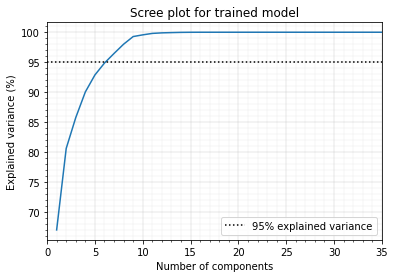

In [ ]:
pca_analysis(NOAA_df_no_dups, NOAA_all_EF_features, 'damage_class')

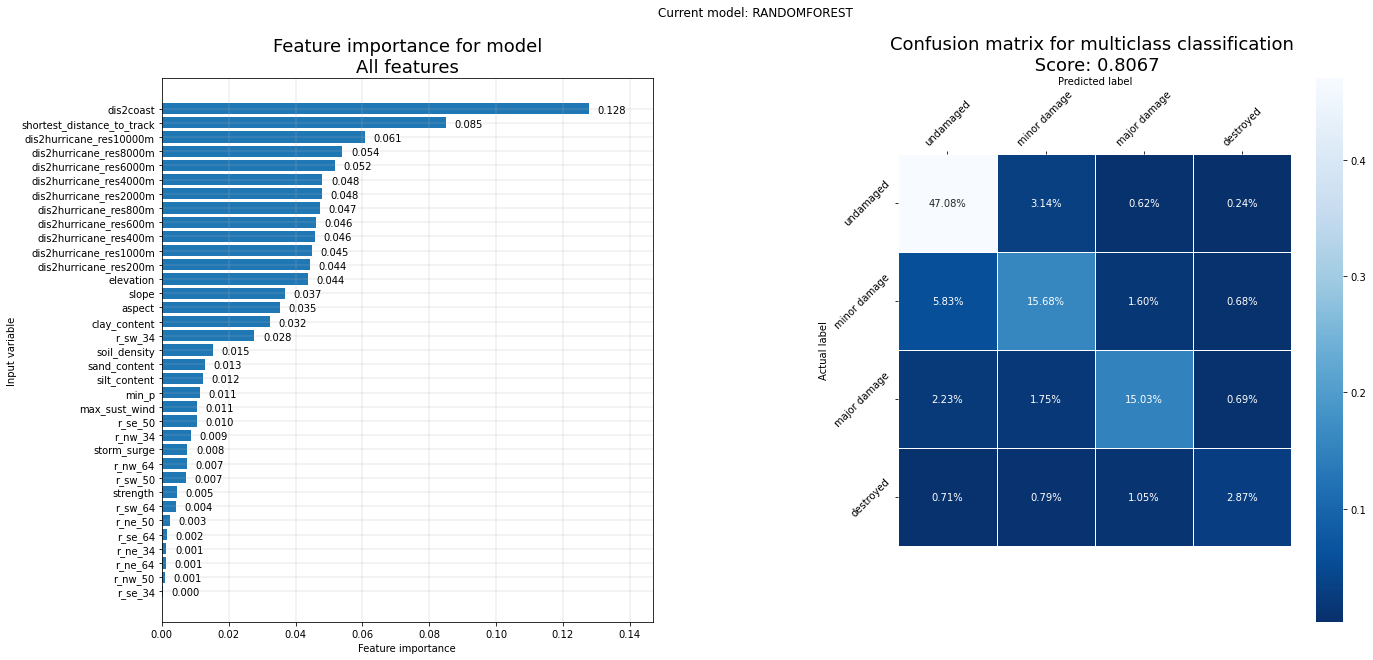

f1 score per class: [0.88060493 0.69461178 0.79113232 0.57983193]
f1 score macro: 0.7365452395413252
weighted f1 score: 0.8110295708359643
precision score: [0.92173977 0.65920279 0.76299137 0.5292887 ]
recall score: [0.84298471 0.73404067 0.82142857 0.6410473 ]
balanced accuracy: 0.7598753129581849
accuracy_score: 0.8067258643491404


In [ ]:
# assign target variable
NOAA_df_model_ready = assign_predictor(NOAA_df_no_dups, 'damage_class', drop_classes=[4], binary_classification=False)

# replace necessary columns with mean TODO: ask Ruari about this
#cols_for_mean = ['soil_density', 'sand_content', 'clay_content', 'silt_content']
#df_model_ready = replace_cols_with_mean(df_model_ready, cols_for_mean)
ECMWF_df_model_ready.head()

model_NOAA, predictions_NOAA, x_train_NOAA, x_test_NOAA, y_train_NOAA, y_test_NOAA, score_NOAA, y_score_NOAA, importances_NOAA = train_test_display_model(
    NOAA_df_model_ready, NOAA_all_EF_features, model_name='RandomForest')

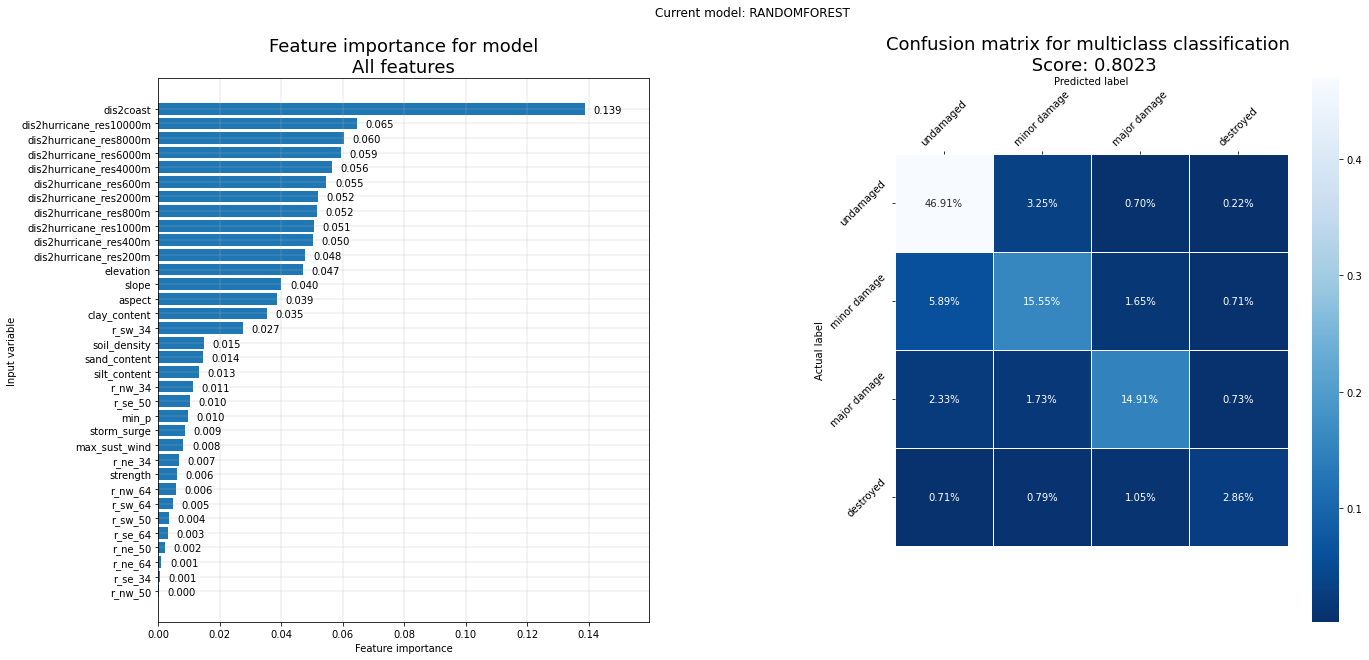

f1 score per class: [0.87747818 0.68928542 0.78445792 0.57576908]
f1 score macro: 0.7317476482058886
weighted f1 score: 0.8066631913564877
precision score: [0.91833716 0.65332698 0.75685523 0.52859135]
recall score: [0.84010015 0.72943262 0.81415017 0.63219349]
balanced accuracy: 0.7539691081446835
accuracy_score: 0.802342716795768


In [ ]:
model_NOAA, predictions_NOAA, x_train_NOAA, x_test_NOAA, y_train_NOAA, y_test_NOAA, score_NOAA, y_score_NOAA, importances_NOAA = train_test_display_model(
    NOAA_df_model_ready, NOAA_all_EF_features_notrack, model_name='RandomForest')

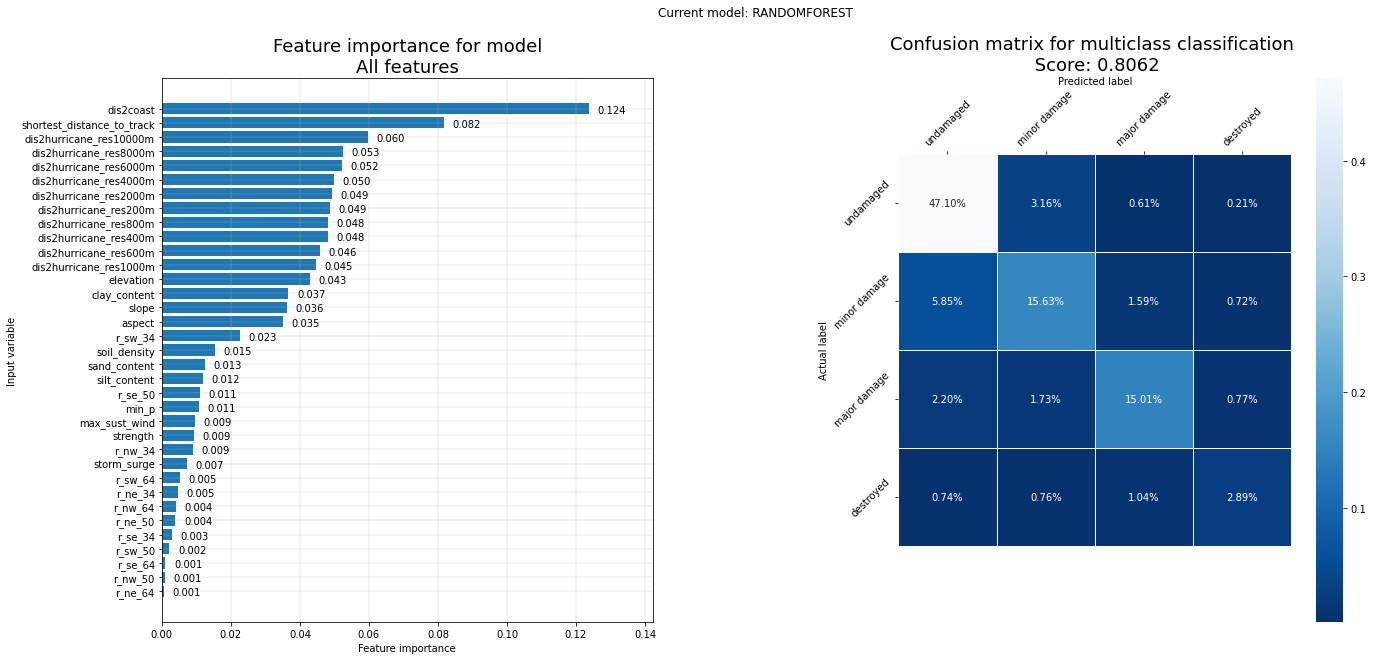

f1 score per class: [0.88060756 0.69343616 0.79084121 0.57747543]
f1 score macro: 0.7355900930723538
weighted f1 score: 0.8105105677713658
precision score: [0.92203565 0.65682071 0.76164909 0.53277545]
recall score: [0.84274221 0.734375   0.82236025 0.63036304]
balanced accuracy: 0.7574601232125888
accuracy_score: 0.8062346495371245


In [ ]:
# assign target variable
NOAA_df_model_ready = assign_predictor(NOAA_df_no_dups, 'damage_class', drop_classes=[4], binary_classification=False)

# replace necessary columns with mean TODO: ask Ruari about this
#cols_for_mean = ['soil_density', 'sand_content', 'clay_content', 'silt_content']
#df_model_ready = replace_cols_with_mean(df_model_ready, cols_for_mean)
ECMWF_df_model_ready.head()

model_NOAA, predictions_NOAA, x_train_NOAA, x_test_NOAA, y_train_NOAA, y_test_NOAA, score_NOAA, y_score_NOAA, importances_NOAA = train_test_display_model(
    NOAA_df_model_ready, NOAA_all_EF_features, model_name='RandomForest')

## Run all features

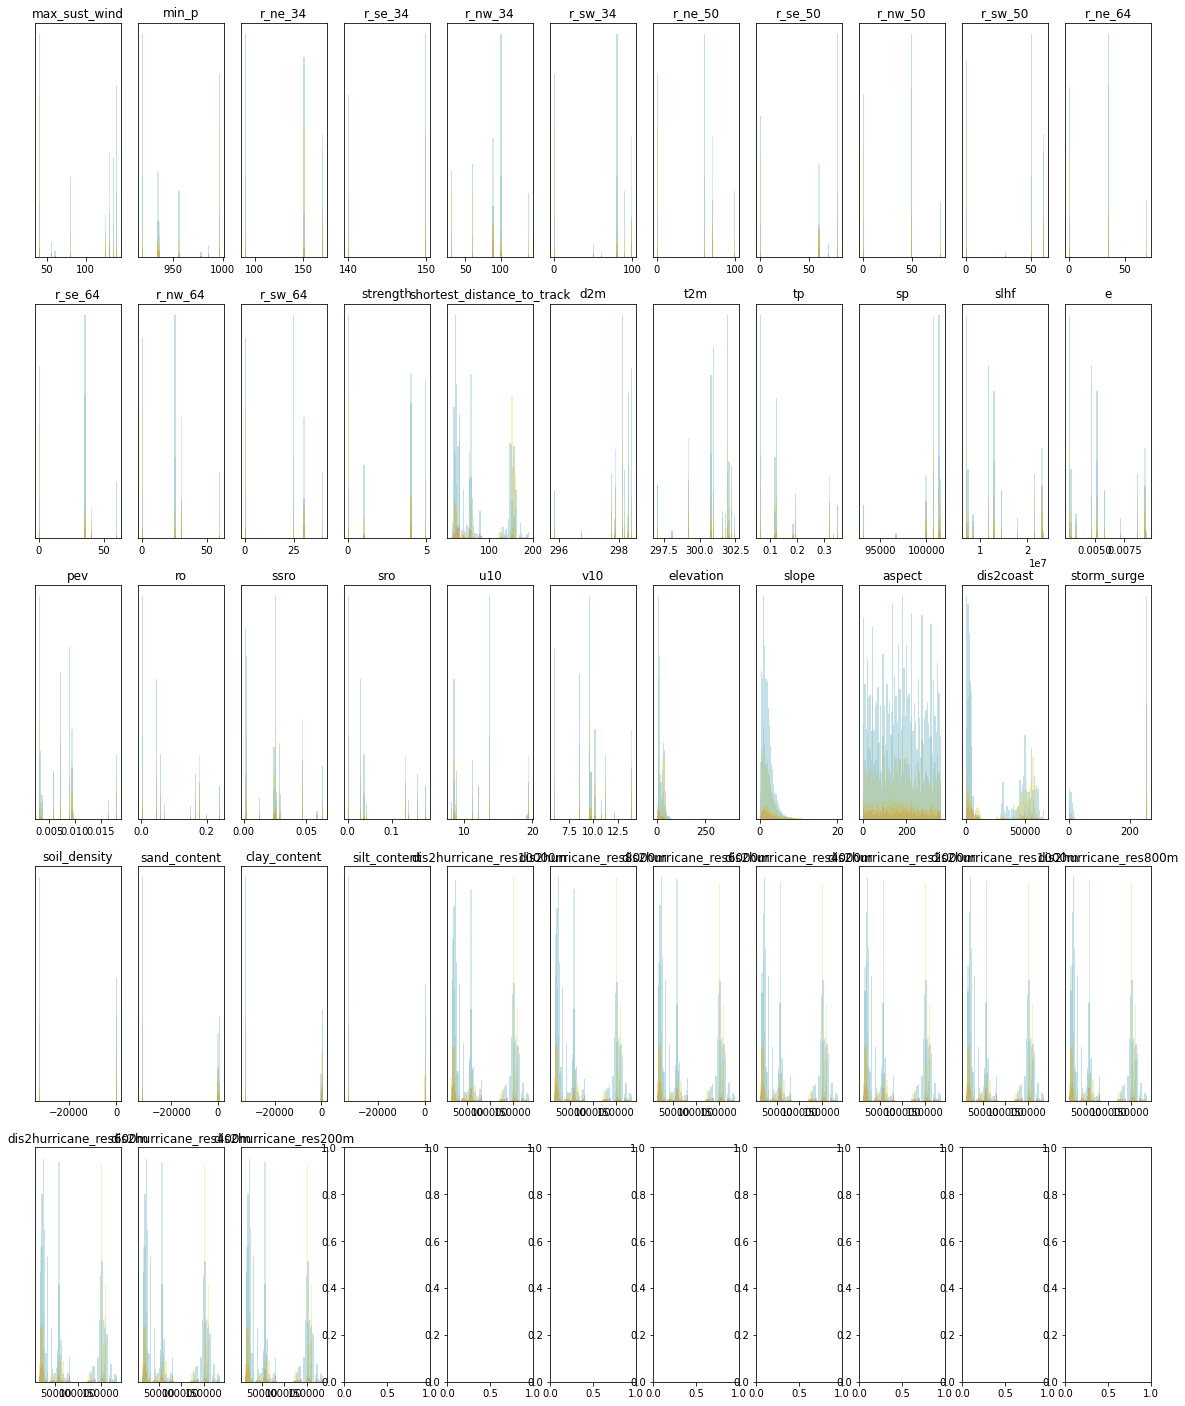

In [ ]:
all_EF_df = all_df_no_dups.dropna(subset=all_EF_features)

# TODO: make more clear
fig, axes = plt.subplots(5, 11, figsize=(20,25))	# better way to dynamically assign for a variable number of figures?

axes = axes.ravel()
bins = 60
palette = ["#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00"]

# for each feature
for f_ind, f in enumerate(all_EF_features):
	# and each damage class
	for t in all_df_no_dups['damage_class'].unique():
		damage_data = all_df_no_dups[all_df_no_dups['damage_class'] == t]
		axes[f_ind].hist(damage_data[f], bins=bins, color=palette[t], alpha=0.3)
		axes[f_ind].axes.get_yaxis().set_visible(False)
	axes[f_ind].set_title(f)
	# TODO: add overall legend
	# axes[f].legend

Variances (Percentage):
[5.07085331e+01 1.62716594e+01 9.48024516e+00 5.69583862e+00
 3.86463894e+00 3.07911160e+00 2.10519045e+00 1.89864600e+00
 1.84402589e+00 1.35805910e+00 1.14619328e+00 9.45864249e-01
 9.04135205e-01 2.09969741e-01 1.81815266e-01 1.24483431e-01
 6.63122109e-02 3.29579594e-02 2.68389003e-02 1.73364677e-02
 1.36027815e-02 1.21276016e-02 7.75840472e-03 3.49359678e-03
 4.45879462e-04 2.89148067e-04 2.53946896e-04 1.57170133e-04
 6.93689855e-06 6.30120019e-06 2.49194098e-06 6.13485022e-07
 1.46611505e-07 1.12096122e-08 6.47338325e-10 2.87235740e-10
 7.81367156e-11 1.10319029e-11 2.53142107e-28 2.61715947e-29
 2.12788851e-29 6.85981052e-30 2.65951962e-30 7.61758244e-31
 4.21042130e-31 4.21042130e-31 9.09984078e-32]
Cumulative Variances (Percentage):
[ 50.70853305  66.98019249  76.46043765  82.15627627  86.02091521
  89.10002681  91.20521726  93.10386327  94.94788916  96.30594826
  97.45214154  98.39800579  99.30214099  99.51211073  99.693926
  99.81840943  99.88472164 

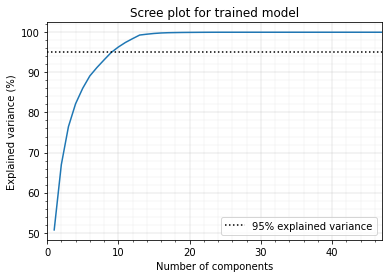

In [ ]:
pca_analysis(all_df_no_dups, all_EF_features, 'damage_class')

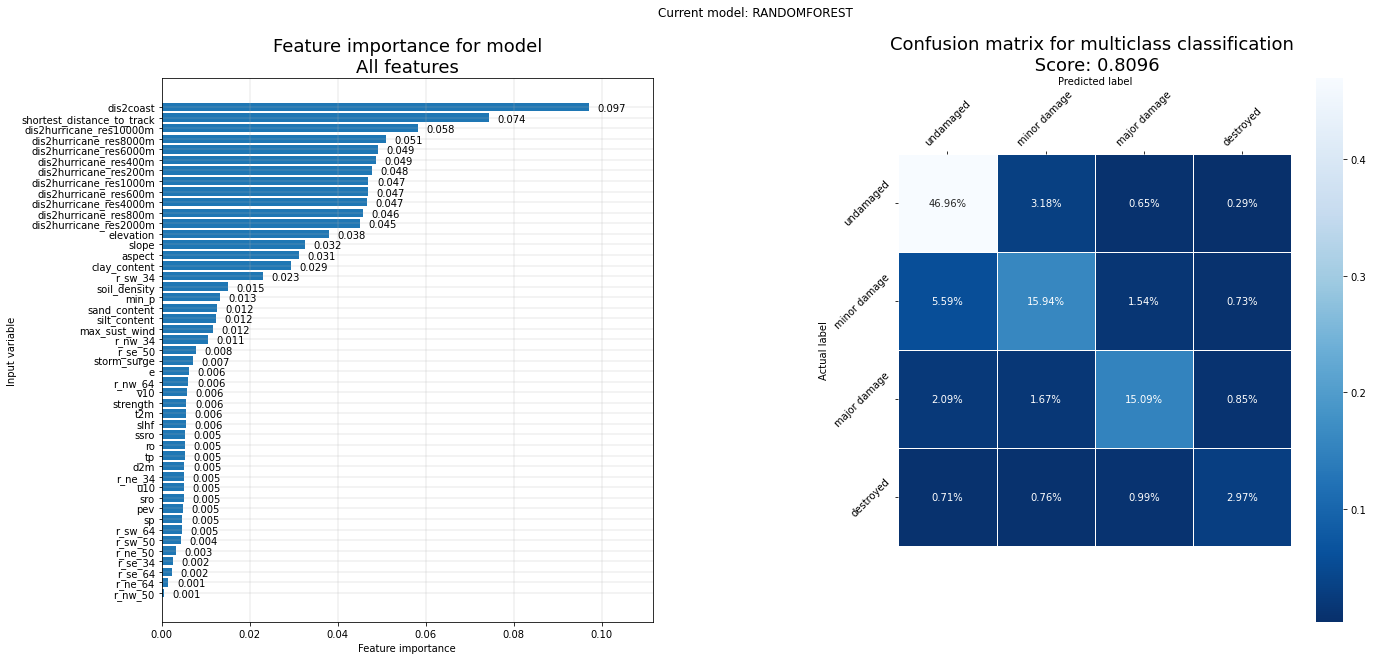

f1 score per class: [0.88248243 0.70294142 0.79482587 0.57869517]
f1 score macro: 0.7397362223028724
weighted f1 score: 0.8130902008446712
precision score: [0.91929876 0.66984278 0.76586769 0.5474198 ]
recall score: [0.8485014  0.73948107 0.82605998 0.61376075]
balanced accuracy: 0.7569507988566352
accuracy_score: 0.8095597959569243


In [ ]:
# assign target variable
all_df_model_ready = assign_predictor(all_df_no_dups, 'damage_class', drop_classes=[4], binary_classification=False)

# replace necessary columns with mean TODO: ask Ruari about this
#cols_for_mean = ['soil_density', 'sand_content', 'clay_content', 'silt_content']
#df_model_ready = replace_cols_with_mean(df_model_ready, cols_for_mean)
all_df_model_ready.head()

model_all, predictions_all, x_train_all, x_test_all, y_train_all, y_test_all, score_all, y_score_all, importances_all = train_test_display_model(
    all_df_model_ready, all_EF_features, model_name='RandomForest')

## Compare weather features only

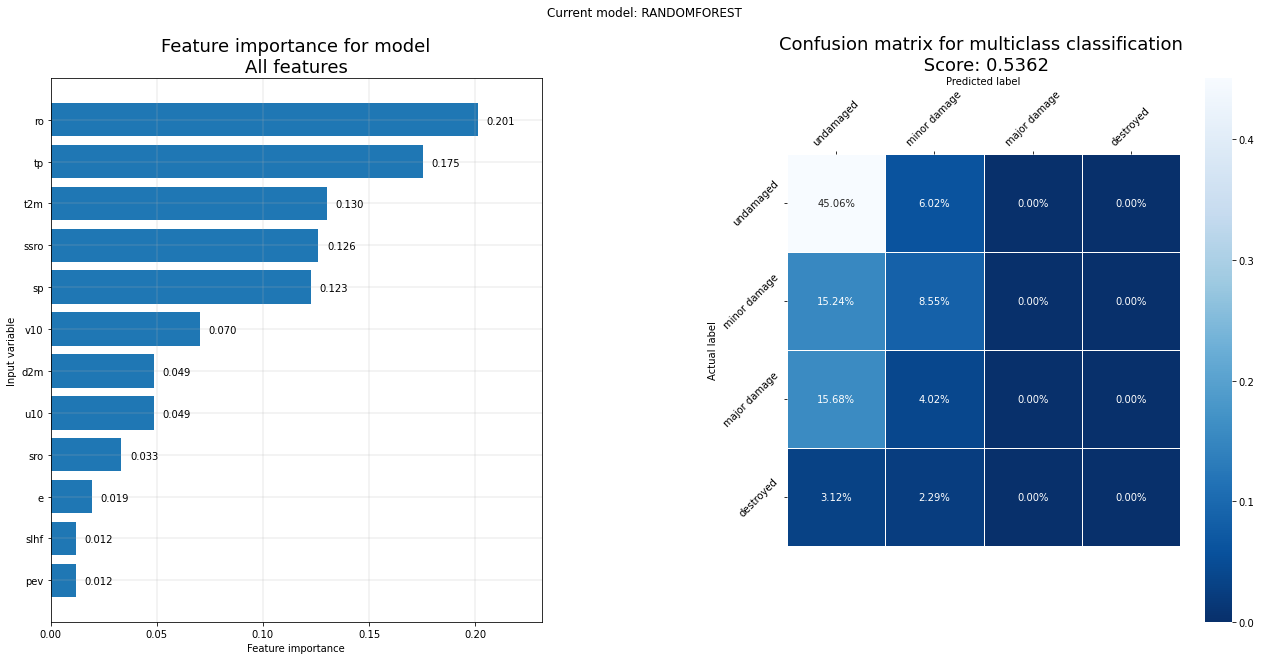

f1 score per class: [0.69224518 0.38291755 0.         0.        ]
f1 score macro: 0.26879068245753635
weighted f1 score: 0.6276329334580575
precision score: [0.88216584 0.35953629 0.         0.        ]
recall score: [0.5696136  0.40955137 0.         0.        ]
balanced accuracy: 0.24479124438300084
accuracy_score: 0.5361798601927074


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# for ECMWF
ECMWF_w_model, ECMWF_w_predictions, ECMWF_w_x_train, ECMWF_w_x_test, ECMWF_w_y_train, ECMWF_w_y_test, ECMWF_w_score, ECMWF_w_y_score, ECMWF_w_importances = train_test_display_model(
    ECMWF_df_model_ready, ECMWF_weather_features, model_name='RandomForest')

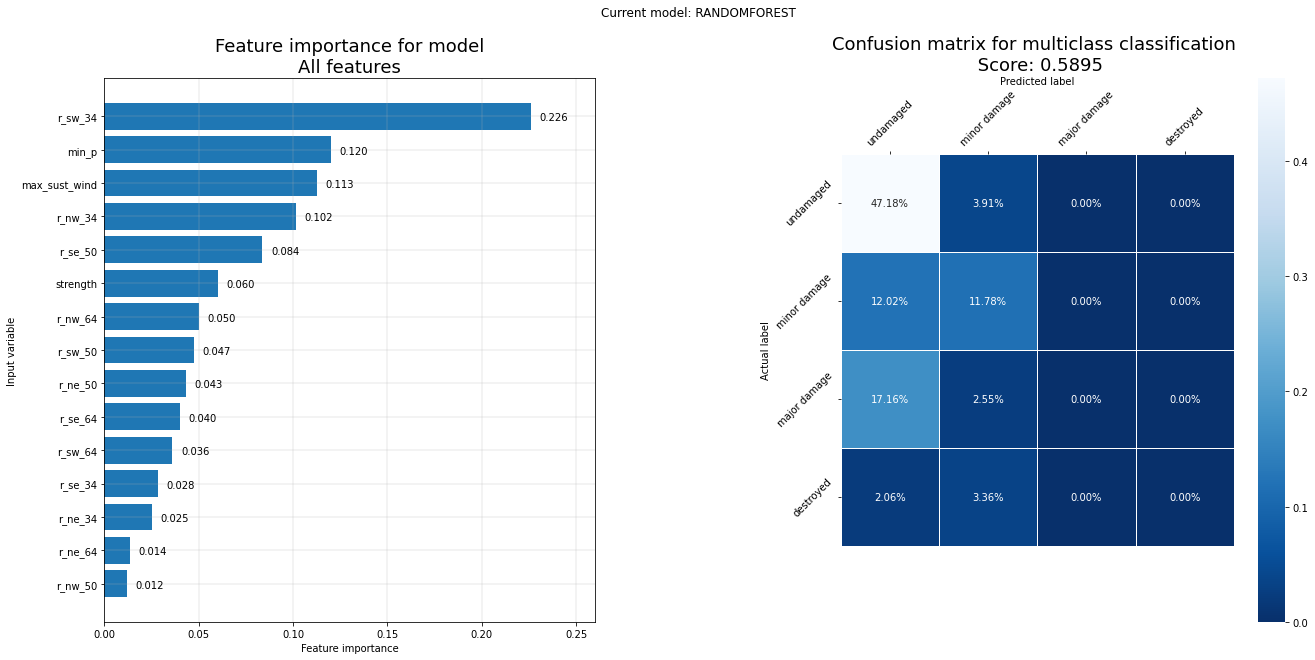

f1 score per class: [0.72860436 0.51906744 0.         0.        ]
f1 score macro: 0.3119179507919332
weighted f1 score: 0.6833716218430445
precision score: [0.92351505 0.49499762 0.         0.        ]
recall score: [0.60162876 0.54559776 0.         0.        ]
balanced accuracy: 0.28680662954243735
accuracy_score: 0.589533345928585


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# for NOAA
NOAA_w_model, NOAA_w_predictions, NOAA_w_x_train, NOAA_w_x_test, NOAA_w_y_train, NOAA_w_y_test, NOAA_w_score, NOAA_w_y_score, NOAA_w_importances = train_test_display_model(
    NOAA_df_model_ready, NOAA_weather_features, model_name='RandomForest')

Based on f1 score, precision, recall and accuracy, the NOAA dataset provides the most information

## Compare interpolation of tracks
for the top three performing distance to hurricane track, res 1000, res8000 and res600.

In [ ]:
NOAA_EF_features_loop_track = [['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength',
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'dis2hurricane_res10000m'], ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'dis2hurricane_res8000m'], ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'dis2hurricane_res6000m'],
       ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64',
       'strength', 
       'elevation', 'slope',
       'aspect', 'dis2coast','storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content',
       'shortest_distance_to_track']]

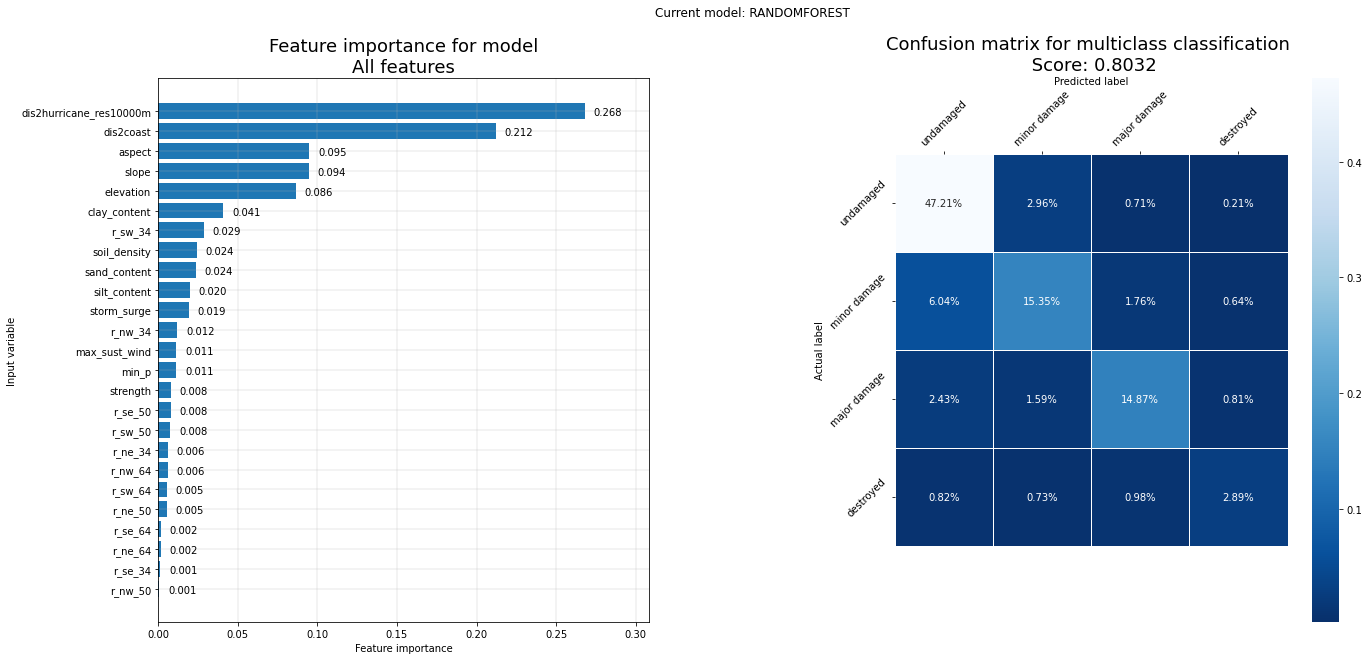

f1 score per class: [0.87766499 0.6909926  0.78199523 0.57998484]
f1 score macro: 0.7326594150309811
weighted f1 score: 0.8080809816922161
precision score: [0.92418078 0.64506908 0.75455417 0.5334728 ]
recall score: [0.83560728 0.74395604 0.81150753 0.63538206]
balanced accuracy: 0.7566132269251106
accuracy_score: 0.803174003400718


In [ ]:
model_10000m, predictions_10000m, x_train_10000m, x_test_10000m, y_train_10000m, y_test_10000m, score_10000m, y_score_10000m, importances_10000m = train_test_display_model(
    NOAA_df_model_ready, NOAA_EF_features_loop_track[0], model_name='RandomForest')

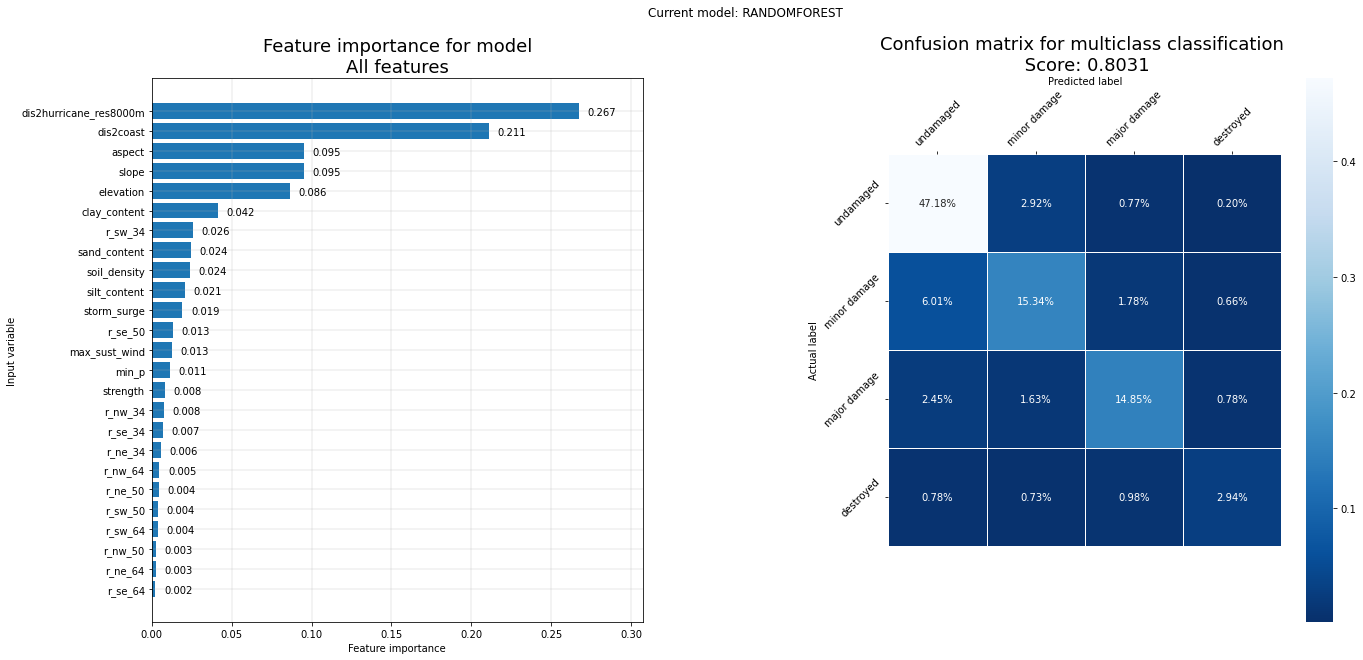

f1 score per class: [0.87782074 0.69082865 0.77964084 0.58707971]
f1 score macro: 0.7338424856198652
weighted f1 score: 0.8078932224137038
precision score: [0.92366299 0.64475147 0.75340364 0.541841  ]
recall score: [0.83631371 0.74399853 0.80777138 0.64056059]
balanced accuracy: 0.7571610547182693
accuracy_score: 0.8030606461364066


In [ ]:
model_8000m, predictions_8000m, x_train_8000m, x_test_8000m, y_train_8000m, y_test_8000m, score_8000m, y_score_8000m, importances_8000m = train_test_display_model(
    NOAA_df_model_ready, NOAA_EF_features_loop_track[1], model_name='RandomForest')

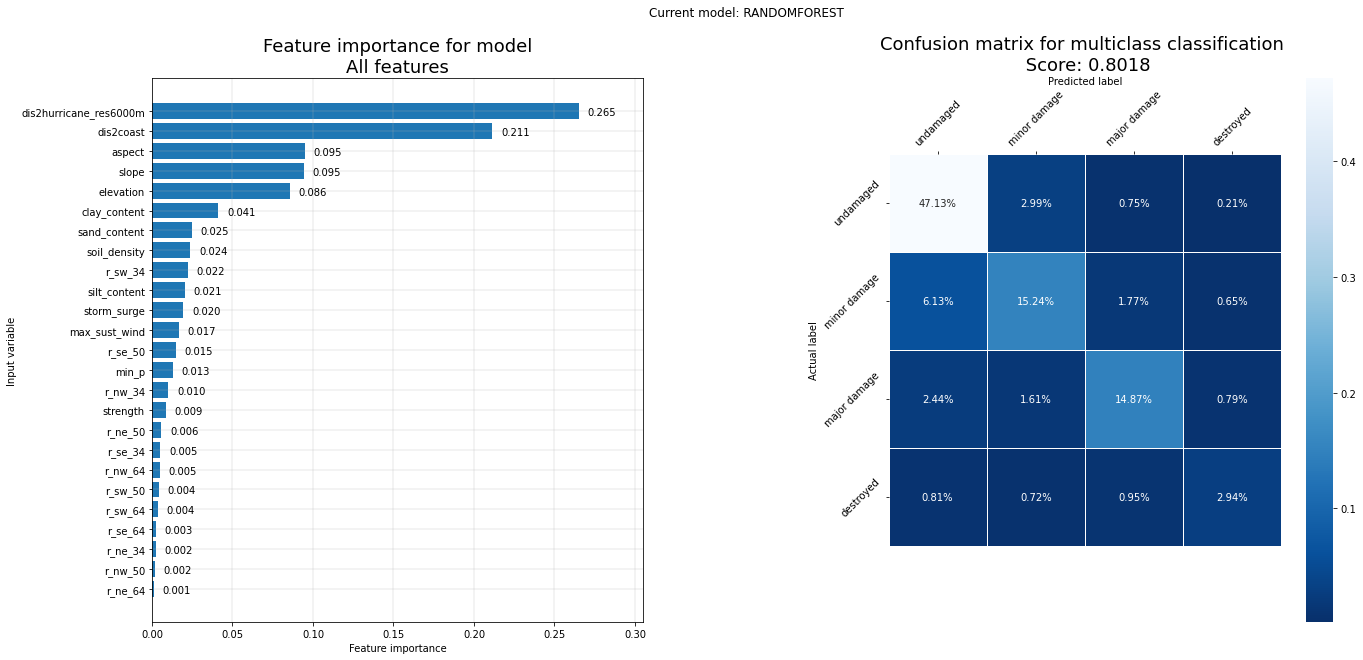

f1 score per class: [0.87610619 0.68728698 0.78160691 0.58663647]
f1 score macro: 0.7329091384545731
weighted f1 score: 0.8066789154997193
precision score: [0.92270138 0.64046371 0.75455417 0.541841  ]
recall score: [0.83399077 0.7414966  0.81067161 0.63950617]
balanced accuracy: 0.7564162890180617
accuracy_score: 0.8017759304742113


In [ ]:
model_6000m, predictions_6000m, x_train_6000m, x_test_600m, y_train_600m, y_test_6000m, score_6000m, y_score_6000m, importances_6000m = train_test_display_model(
    NOAA_df_model_ready, NOAA_EF_features_loop_track[2], model_name='RandomForest')

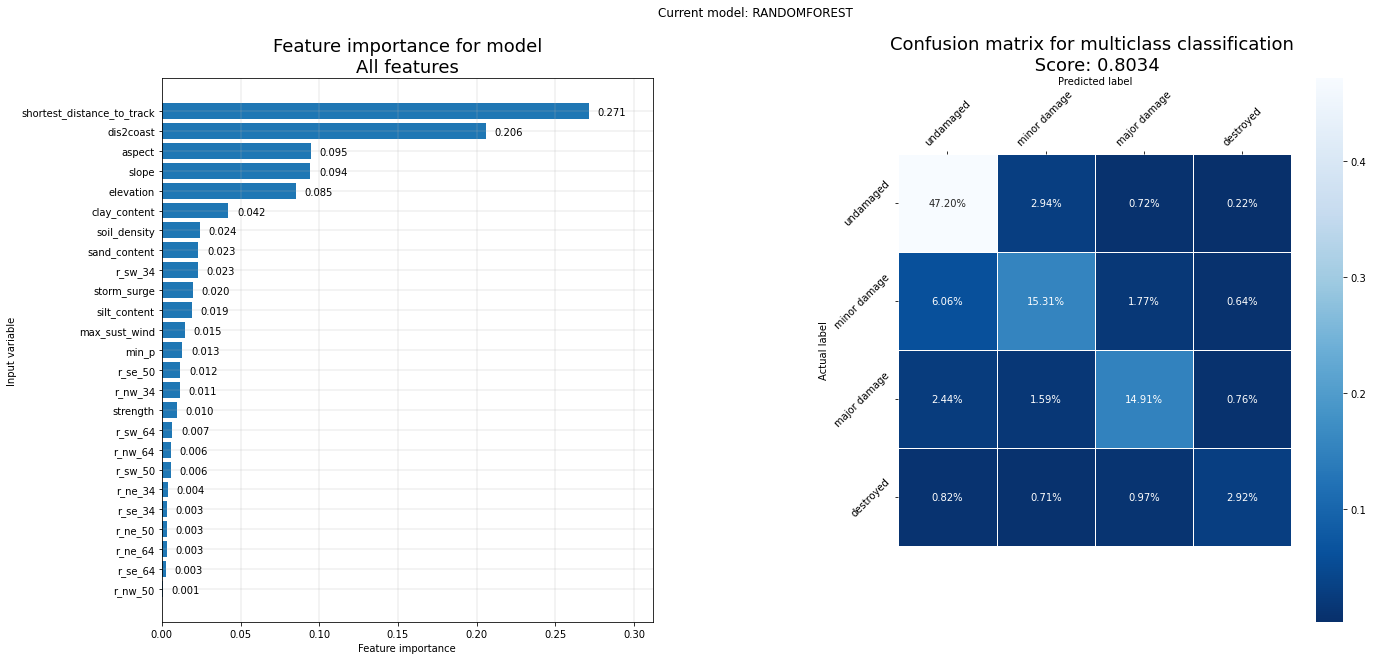

f1 score per class: [0.87726938 0.69051878 0.78297112 0.58551384]
f1 score macro: 0.7340682806679348
weighted f1 score: 0.8082817790956247
precision score: [0.92395887 0.64363983 0.75647172 0.53835425]
recall score: [0.83507153 0.74476295 0.81139449 0.64172901]
balanced accuracy: 0.7582394967737287
accuracy_score: 0.8033629321745702


In [ ]:
model_shortest, predictions_shortest, x_train_shortest, x_test_shortest, y_train_shortest, y_test_shortest, score_shortest, y_score_shortest, importances_shortest = train_test_display_model(
    NOAA_df_model_ready, NOAA_EF_features_loop_track[3], model_name='RandomForest')

In [ ]:
all_EF_features_shortesttrack = ['max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64', 'strength',
       'shortest_distance_to_track', 'd2m', 't2m', 'tp',
       'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro', 'u10', 'v10',
       'elevation', 'slope', 'aspect', 'dis2coast',
       'storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content']

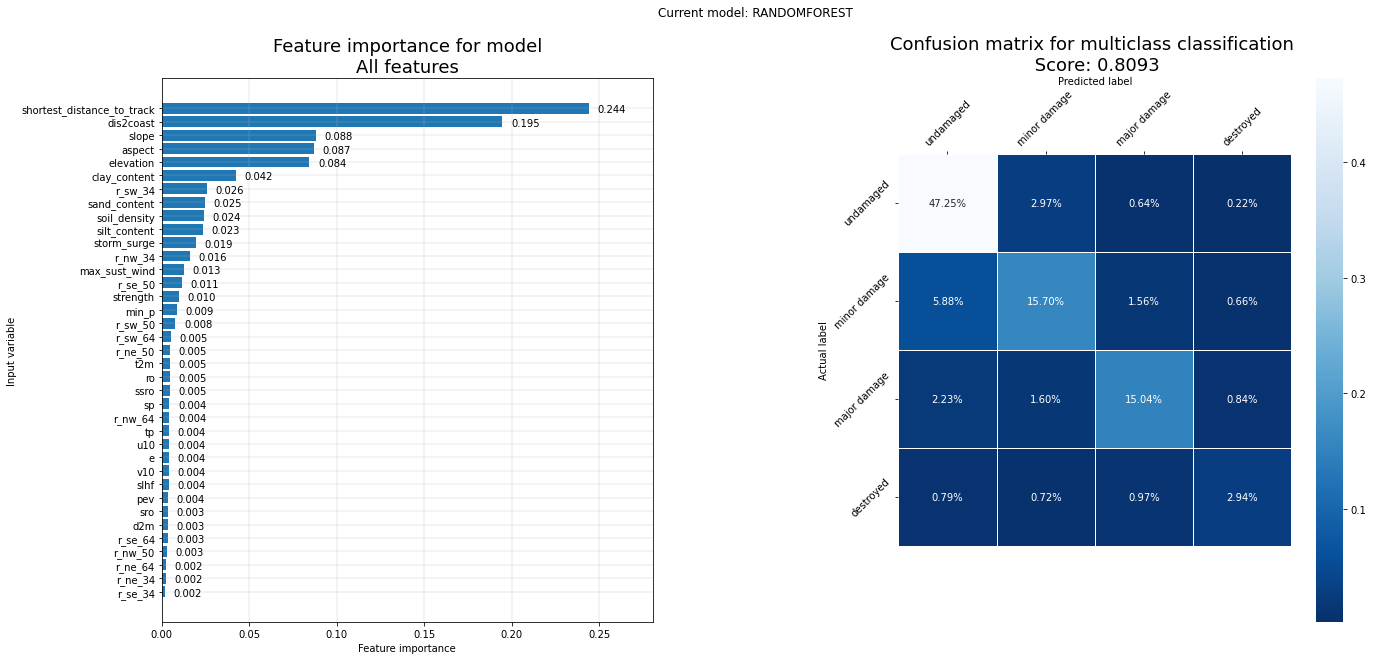

f1 score per class: [0.88137863 0.70108833 0.79322372 0.58289572]
f1 score macro: 0.7396466007043425
weighted f1 score: 0.8135784970376405
precision score: [0.92499445 0.65983802 0.76318313 0.541841  ]
recall score: [0.84169079 0.74784017 0.82572614 0.63068182]
balanced accuracy: 0.761484729383789
accuracy_score: 0.8092575099187607


In [ ]:
all_model_shortest, all_predictions_shortest, all_x_train_shortest, all_x_test_shortest, all_y_train_shortest, all_y_test_shortest, all_score_shortest, all_y_score_shortest, all_importances_shortest = train_test_display_model(
    all_df_model_ready, all_EF_features_shortesttrack, model_name='RandomForest')

Variances (Percentage):
[3.96110352e+01 2.02355636e+01 1.16394261e+01 7.22331501e+00
 4.64005652e+00 3.82229156e+00 2.67387100e+00 2.36486511e+00
 2.16128514e+00 1.72486120e+00 1.37815171e+00 1.19967690e+00
 5.46185433e-01 2.64486417e-01 1.77603819e-01 1.51112383e-01
 4.69273996e-02 3.72487067e-02 3.40161500e-02 2.19455772e-02
 1.71976825e-02 1.52213940e-02 9.83876933e-03 2.71493553e-03
 5.66301857e-04 3.27595653e-04 1.99588195e-04 8.75912891e-06
 2.67059099e-28 2.87892708e-29 2.09858825e-29 1.53124059e-29
 4.26034186e-30 1.21792775e-30 3.09892977e-31 2.55557116e-31
 1.00499025e-31]
Cumulative Variances (Percentage):
[ 39.6110352   59.84659882  71.48602496  78.70933996  83.34939648
  87.17168804  89.84555904  92.21042415  94.37170929  96.09657048
  97.47472219  98.67439909  99.22058452  99.48507094  99.66267476
  99.81378714  99.86071454  99.89796325  99.9319794   99.95392497
  99.97112266  99.98634405  99.99618282  99.99889776  99.99946406
  99.99979165  99.99999124 100.         100. 

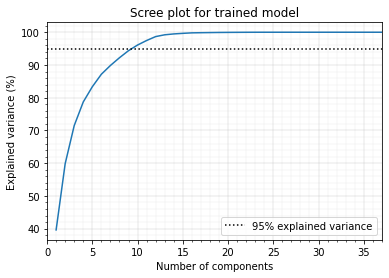

In [ ]:
pca_analysis(all_df_no_dups, all_EF_features_shortesttrack, 'damage_class')

Conclusion: best performing is all dataframe with shortest track, but will choose top 15

In [ ]:
EF_all_best_features = ["shortest_distance_to_track", "dis2coast", "slope", "aspect", "elevation", "clay_content", "sand_content", "soil_density", "silt_content", "storm_surge", "r_sw_34", "min_p", "r_nw_34", "max_sust_wind"]

In [ ]:
all_df_no_dups.columns

Index(['xbd_obs_geometry', 'polygon_lnglat', 'pointy', 'polygony',
       'disaster_name', 'image_name', 'capture_date', 'json_link',
       'damage_class', 'xbd_obs_lon', 'xbd_obs_lat', 'noaa_index', 'tag',
       'num_entries', 'noaa_obs_date', 'record_id', 'sys_status',
       'noaa_obs_lat', 'noaa_obs_lon', 'max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64', 'strength',
       'noaa_obs_geometry', 'shortest_distance_to_track', 'd2m', 't2m', 'tp',
       'sp', 'slhf', 'e', 'pev', 'ro', 'ssro', 'sro', 'u10', 'v10',
       'xbd_index', 'name_y', 'elevation', 'slope', 'aspect', 'dis2coast',
       'disaster_name_y', 'storm_surge', 'soil_density', 'sand_content',
       'clay_content', 'silt_content', 'dis2hurricane_res10000m',
       'dis2hurricane_res8000m', 'dis2hurricane_res6000m',
       'dis2hurricane_res4000m', 'dis2hurricane_res2000m',
       'dis2hurricane_res

# This space is JUST for rlazando


In [ ]:
filtered_df = pd.read_pickle('/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/processed_data/metadata_pickle/filtered_lnglat_pre_pol_post_damage.pkl')

In [ ]:
filtered_df.columns

Index(['xbd_obs_geometry', 'polygon_lnglat', 'pointy', 'polygony',
       'disaster_name', 'image_name', 'capture_date', 'json_link',
       'damage_class', 'xbd_obs_lon', 'xbd_obs_lat', 'noaa_index', 'tag',
       'num_entries', 'noaa_obs_date', 'record_id', 'sys_status',
       'noaa_obs_lat', 'noaa_obs_lon', 'max_sust_wind', 'min_p', 'r_ne_34',
       'r_se_34', 'r_nw_34', 'r_sw_34', 'r_ne_50', 'r_se_50', 'r_nw_50',
       'r_sw_50', 'r_ne_64', 'r_se_64', 'r_nw_64', 'r_sw_64', 'strength',
       'noaa_obs_geometry', 'shortest_distance_to_track', 'elevation', 'slope',
       'aspect', 'dis2coast', 'disaster_name_y', 'storm_surge', 'soil_density',
       'sand_content', 'clay_content', 'silt_content', 'damage_categorical'],
      dtype='object')

In [ ]:
def generate_test_train_from_event_subset(
    df: pd.DataFrame,
    var_col_names: list[str],
    y_col: str,
    train_event_names: list[str],
    test_event_names: list[str],
    test_size: float = 0.25,
    random_state: int = 1
):
    """train_event_names and test_event_names should not overlap"""
    # limit training df to specified events 
    df_train_lim = df[df['disaster_name'].isin(train_event_names)]
    df_test_lim = df[df['disaster_name'].isin(test_event_names)]

    x_train, _, y_train, _ = train_test_split(
        df_train_lim[var_col_names],
        df_train_lim[y_col],
        test_size=test_size,
        random_state=random_state)
  
    _, x_test, _, y_test = train_test_split(
        df_test_lim[var_col_names],
        df_test_lim[y_col],
        test_size=test_size,
        random_state=random_state)
    
    # remove hungover index names
    y_train.index.name = None
    y_test.index.name = None

    return x_train, y_train, x_test, y_test


def run_model_from_splits(
    x_train, x_test,
    y_train, y_test,
    model_name,
    var_col_names
):

    # select chosen model
    if model_name == 'LogisticRegression':
        model = LogisticRegression()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.coef_[0]
    elif model_name == 'RandomForest':
        model = RandomForestClassifier()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.feature_importances_ 

    predictions = model.predict(x_test)
    score = model.score(x_test, y_test)
    y_score = model.predict_proba(x_test)

    fig,(ax_imp,ax_conf) = plt.subplots(1, 2, figsize=[22,10])
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(f'Current model: {model_name.upper()}')

    plot_confusion_matrix(y_test, predictions, score, ax=ax_conf)
    plot_importances(var_col_names, importance, ax=ax_imp)
    plt.show()

    more_performance_scores(predictions,y_test)

    return model, predictions, x_train, x_test, y_train, y_test, score, y_score, importance


def train_test_display_model(
    df: pd.DataFrame,
    var_col_names: List[str],
    model_name: str = 'LogisticRegression',
    y_col: str = 'y',
    test_size: float = 0.25,
    random_state: int = 1
) -> list:
    """Specify columns in a df to use to train and test model. Currently available models: 'LogisticRegression', 
    'RandomForest'
    """

    x_train, x_test, y_train, y_test = train_test_split(
        df[var_col_names],
        df[y_col],
        test_size=test_size,random_state=random_state)

    # select chosen model
    if model_name == 'LogisticRegression':
        model = LogisticRegression()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.coef_[0]
    elif model_name == 'RandomForest':
        model = RandomForestClassifier()
        model = train_test_model(model, [x_train, y_train], [x_test, y_test])
        importance = model.feature_importances_  

    predictions = model.predict(x_test)
    score = model.score(x_test, y_test)
    y_score = model.predict_proba(x_test)

    fig,(ax_imp,ax_conf) = plt.subplots(1, 2, figsize=[22,10])
    fig.subplots_adjust(wspace=0.5)
    fig.suptitle(f'Current model: {model_name.upper()}')

    plot_confusion_matrix(y_test, predictions, score, ax=ax_conf)
    plot_importances(var_col_names, importance, ax=ax_imp)
    plt.show()

    more_performance_scores(predictions,y_test)

    return model, predictions, x_train, x_test, y_train, y_test, score, y_score, importance

In [ ]:
best_features_filtered_df = filtered_df[EF_all_best_features + ['disaster_name', 'damage_class']]
best_features_filtered_df = assign_predictor(best_features_filtered_df, 'damage_class', drop_classes=[4], binary_classification=False)
best_features_filtered_df.head()

<ipython-input-4-a6ebfb6bf1a7>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y"] = df[col_name].astype(int)


,shortest_distance_to_track,dis2coast,slope,aspect,elevation,clay_content,sand_content,soil_density,silt_content,storm_surge,r_sw_34,min_p,r_nw_34,max_sust_wind,disaster_name,damage_class,y
xbd_index,,,,,,,,,,,,,,,,,
106181,22.2315,544.846928,0.951972,156.801407,13,-32768,-32768,-32768,-32768,4,80.0,919.0,100.0,140,MICHAEL,0,0
108825,31.271708,1404.657747,1.581139,18.434948,12,21,946,121,33,9,80.0,919.0,100.0,140,MICHAEL,0,0
107355,24.114182,1304.633238,0.790569,341.565063,8,-32768,-32768,-32768,-32768,7,80.0,920.0,100.0,135,MICHAEL,0,0
37776,162.232242,62117.140611,2.926175,250.016891,36,-32768,-32768,-32768,-32768,255,0.0,997.0,30.0,40,HARVEY,0,0
94560,149.838526,55360.134966,1.38067,84.805573,36,-32768,-32768,-32768,-32768,255,0.0,997.0,30.0,40,HARVEY,0,0


In [ ]:
best_features_filtered_df[best_features_filtered_df.disaster_name == 'MICHAEL']

,shortest_distance_to_track,dis2coast,slope,aspect,elevation,clay_content,sand_content,soil_density,silt_content,storm_surge,r_sw_34,min_p,r_nw_34,max_sust_wind,disaster_name,damage_class,y
xbd_index,,,,,,,,,,,,,,,,,
106181,22.2315,544.846928,0.951972,156.801407,13,-32768,-32768,-32768,-32768,4,80.0,919.0,100.0,140,MICHAEL,0,0
108825,31.271708,1404.657747,1.581139,18.434948,12,21,946,121,33,9,80.0,919.0,100.0,140,MICHAEL,0,0
107355,24.114182,1304.633238,0.790569,341.565063,8,-32768,-32768,-32768,-32768,7,80.0,920.0,100.0,135,MICHAEL,0,0
81263,20.804598,1029.609097,3.005204,196.927505,7,-32768,-32768,-32768,-32768,255,80.0,920.0,100.0,135,MICHAEL,0,0
108867,30.968271,1222.826029,4.031129,150.255112,4,21,946,121,33,12,80.0,919.0,100.0,140,MICHAEL,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17861,21.688501,4783.471804,3.051639,145.00798,25,-32768,-32768,-32768,-32768,255,80.0,920.0,100.0,135,MICHAEL,3,3
76308,22.16698,3658.639799,2.298097,337.619873,8,40,884,124,76,255,80.0,919.0,100.0,140,MICHAEL,3,3
82001,27.520419,2373.606579,2.795085,243.434952,14,-32768,-32768,-32768,-32768,255,80.0,919.0,100.0,140,MICHAEL,3,3


In [ ]:
best_features_filtered_df.damage_class.value_counts()

0    5678
2    5678
1    5678
3    5678
Name: damage_class, dtype: int64

In [ ]:
# include plot of x_train and x_test damage levels
y_train_filtered.value_counts().plot.bar()

NameError: ignored

In [ ]:
model_filtered, predictions_filtered, x_train_filtered, x_test_filtered, y_train_filtered, y_test_filtered, score_filtered, y_score_filtered, importances_filtered = train_test_display_model(
    best_features_filtered_df[best_features_filtered_df.disaster_name.isin(['MATTHEW'])], EF_all_best_features, model_name='RandomForest')

In [ ]:
# include plot of x_train and x_test damage levels
y_train_filtered.value_counts().plot.bar()

In [ ]:
plot_pr_curves(y_test_filtered, y_score_filtered)

In [ ]:
# investigate geographic genericness of EFs
# mean of EFs per event

fig, axes = plt.subplots(4, 1, figsize=[28,12])

for i, name in enumerate(best_features_filtered_df.disaster_name.unique()):
    features = best_features_filtered_df[best_features_filtered_df.disaster_name == name][EF_all_best_features]
    # print(name, features.min(), features.max(), features.mean(), features.var())
    sns.boxplot(ax=axes[i], x="variable", y="value", data=pd.melt(features))
    axes[i].set_title(name)
    axes[i].set_yscale('log')

In [ ]:
best_features_filtered_df[EF_all_best_features].columns

In [ ]:
fig, axes = plt.subplots(int(np.ceil(len(all_EF_features)/2)), 2, figsize=[10, 10*len(all_EF_features)])
axes = axes.ravel()
# group data by disaster_name column
grouped = all_df_no_dups.groupby('disaster_name')

# loop through each parameter column and create boxplot
for p, parameter in enumerate(all_EF_features):
    data = [group[1][parameter] for group in grouped]
    axes[p].boxplot(data, labels=grouped.groups.keys())
    axes[p].set_title(parameter)


In [ ]:
x_train_mi_f_h, y_train_mi_f_h, x_test_mi_f_h, y_test_mi_f_h = generate_test_train_from_event_subset(
    best_features_filtered_df,
    var_col_names = EF_all_best_features,
    y_col = 'y',
    train_event_names = ['MICHAEL', 'MICHAEL', 'MATTHEW'],
    test_event_names = ['FLORENCE'],
)

all_model_us, all_predictions_us, all_x_train_us, all_x_test_us, all_y_train_us, all_y_test_us, all_score_us, all_y_score_us, all_importances_us = run_model_from_splits(
    x_train_mi_f_h, x_test_mi_f_h, y_train_mi_f_h, y_test_mi_f_h, 'RandomForest', EF_all_best_features)

In [ ]:
best_features_df = all_df_no_dups[EF_all_best_features + ['disaster_name', 'damage_class']]
best_features_df.head()

best_features_df = assign_predictor(best_features_df, 'damage_class', drop_classes=[4], binary_classification=False)

all_features_df = all_df_no_dups[all_EF_features + ['disaster_name', 'damage_class']]
all_features_df = assign_predictor(all_features_df, 'damage_class', drop_classes=[4], binary_classification=False)

In [ ]:
x_train_mi_f, y_train_mi_f, x_test_mi_f, y_test_mi_f = generate_test_train_from_event_subset(
    all_features_df,
    var_col_names = all_EF_features,
    y_col = 'y',
    train_event_names = ['MICHAEL'],
    test_event_names = ['FLORENCE'],
)

all_model_us, all_predictions_us, all_x_train_us, all_x_test_us, all_y_train_us, all_y_test_us, all_score_us, all_y_score_us, all_importances_us = run_model_from_splits(
    x_train_mi_f, x_test_mi_f, y_train_mi_f, y_test_mi_f, 'RandomForest', EF_all_best_features)

In [ ]:
x_train_mi_f, y_train_mi_f, x_test_mi_f, y_test_mi_f = generate_test_train_from_event_subset(
    all_features_df,
    var_col_names = all_EF_features,
    y_col = 'y',
    train_event_names = ['MICHAEL'],
    test_event_names = ['FLORENCE'],
)

all_model_us, all_predictions_us, all_x_train_us, all_x_test_us, all_y_train_us, all_y_test_us, all_score_us, all_y_score_us, all_importances_us = run_model_from_splits(
    x_train_mi_f, x_test_mi_f, y_train_mi_f, y_test_mi_f, 'RandomForest', EF_all_best_features)

In [ ]:
x_train_mi_f_h, y_train_mi_f_h, x_test_mi_f_h, y_test_mi_f_h = generate_test_train_from_event_subset(
    all_features_df,
    var_col_names = all_EF_features,
    y_col = 'y',
    train_event_names = ['MICHAEL', 'FLORENCE', 'HARVEY'],
    test_event_names = ['MATTHEW'],
)

all_model_us, all_predictions_us, all_x_train_us, all_x_test_us, all_y_train_us, all_y_test_us, all_score_us, all_y_score_us, all_importances_us = run_model_from_splits(
    x_train_mi_f_h, x_test_mi_f_h, y_train_mi_f_h, y_test_mi_f_h, 'RandomForest', EF_all_best_features)

In [ ]:
y_train.value_counts()

In [ ]:
x_train, y_train, x_test, y_test = generate_test_train_from_event_subset(
    best_features_df,
    var_col_names = EF_all_best_features,
    y_col = 'y',
    train_event_names = ['MICHAEL', 'FLORENCE', 'HARVEY'],
    test_event_names = ['MATTHEW'],
)
all_model_us, all_predictions_us, all_x_train_us, all_x_test_us, all_y_train_us, all_y_test_us, all_score_us, all_y_score_us, all_importances_us = run_model_from_splits(
    x_train, x_test, y_train, y_test, 'RandomForest', EF_all_best_features)

In [ ]:
x_train, y_train, x_test, y_test = generate_test_train_from_event_subset(
    best_features_df,
    var_col_names = EF_all_best_features,
    y_col = 'y',
    train_event_names = ['FLORENCE', 'HARVEY'],
    test_event_names = ['MICHAEL'],
)
all_model_us, all_predictions_us, all_x_train_us, all_x_test_us, all_y_train_us, all_y_test_us, all_score_us, all_y_score_us, all_importances_us = run_model_from_splits(
    x_train, x_test, y_train, y_test, 'RandomForest', EF_all_best_features)

# Logistic Regression Model

In [ ]:
model = LogisticRegression(max_iter = 1e6)
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
model.score(x_test, y_test)

In [ ]:
importance = model.coef_[0]
display(importance)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Random forest hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(x_train, y_train)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(rf_random.best_params_)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)

In [ ]:
# this section is Work In Progress. 

from hyperopt import hp,fmin,tpe,STATUS_OK,Trials

space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200,1300,1500])
    }

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = model.score(x_train, y_train)

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
from sklearn.model_selection import cross_val_score
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

In [ ]:
best["criterion"] = "entropy"

In [ ]:
model = RandomForestClassifier(**best)
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)
model.score(x_test, y_test)

In [ ]:
importance = best.feature_importances_
display(importance)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Random Forest Model

In [ ]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
model.score(x_test, y_test)

In [ ]:
importance = model.feature_importances_
display(importance)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# XGBoost Model

In [ ]:
model = XGBClassifier()

In [ ]:
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
model.score(x_test, y_test)

In [ ]:
importance = model.feature_importances_
display(importance)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
names = NOAA_df_model_ready.disaster_name.values.unique()

for i, name in enumerate(names):
  # pick second name
  two_names = name +

In [ ]:
model_matt_mich, predictions_10000m, x_train_10000m, x_test_10000m, y_train_10000m, y_test_10000m, score_10000m, y_score_10000m, importances_10000m = train_test_display_model(
    NOAA_df_model_ready, NOAA_EF_features_loop_track[0], model_name='RandomForest')